# Multi-Model Approach for Chest X-ray Classification: CNNs, Transformers, and Generative Models


Group 29: Maria-Lorena Poupet, Wan Yiliang, Lam Wei Ren, Shao Yanming

## Project Motivation

Medical image classification has become a critical application of deep learning, particularly in diagnosing diseases from radiological scans. The NIH ChestX-ray14 dataset, a widely used benchmark for thoracic disease classification, presents challenges due to its multi-label nature, imbalanced class distribution, and noisy annotations. Traditional convolutional neural networks (CNNs) and Transformers have demonstrated strong feature extraction capabilities for classification tasks. Besides, generative models show promising ability to detect the abnormal. Our project aims to explore the effectiveness of CNNs, Transformers, and generative models in classifying abnormalities in the NIH ChestX-ray14 dataset.

## Dataset Overview

### Licence and attribution

In this project, we will use https://nihcc.app.box.com/v/ChestXray-NIHCC

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

There are 14 different diseases :

1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax;
9. Consolidation;
10. Edema;
11. Emphysema;
12. Fibrosis;
13. Pleural_Thickening;
14. Hernia

In total, there are 15 labels, when adding "No finding".

For more information concerning the dataset, see:
Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, Ronald Summers, ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, IEEE CVPR, pp. 3462-3471, 2017

We acknowledge that the NIH Clinical Center is the data provider.

### General observation of the dataset information in CSV

First of all, let's visualize our dataset structure.

In [ ]:
# ========= All imports needed ========= #
from itertools import combinations
import shutil
import os
import pandas as pd
from pathlib import Path
from glob import glob
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import random
from collections import Counter
import seaborn as sns

In [ ]:
# Load the Database CSV
csv_path_labels = '/content/drive/MyDrive/project/Data_Entry_2017.csv'
df = pd.read_csv(csv_path_labels)

df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
df.shape
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


We can see that one x-ray can have multiple labels ex: Cardiomegaly|Emphysema. We have access to the ages of the patients and their gender. We also have the information of position in which the x-ray was taken : posteroanterior (PA) chest view and Anterior-Posterior (AP). We can see the original shapes of the x-rays, however the images were shaped to 1024x1024 in the dataset. We also have information about the original pixel spacing.

In our case, the main interesting information are the images and the finding labels.

### Observation of class imbalance

No Finding                60361
Infiltration              19894
Effusion                  13317
Atelectasis               11559
Nodule                    6331
Mass                      5782
Pneumothorax              5302
Consolidation             4667
Pleural_Thickening        3385
Cardiomegaly              2776
Emphysema                 2516
Edema                     2303
Fibrosis                  1686
Pneumonia                 1431
Hernia                    227


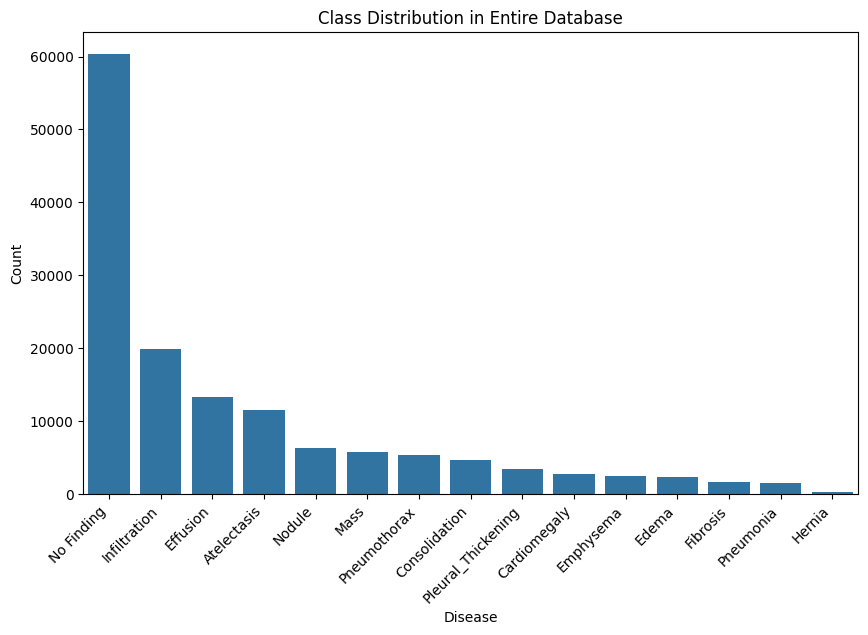

In [ ]:
# Ensure proper data format for "Finding Labels" and handle multi-labels
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# Flatten the list of labels to get the count of each disease
all_labels = [label for sublist in df['Finding Labels'].dropna() for label in sublist]
class_counts_entire = pd.Series(all_labels).value_counts()

# Display the results in a 'table'
for disease, count in class_counts_entire.items():
    print(f"{disease: <25} {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts_entire.index, y=class_counts_entire.values)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Entire Database')
plt.ylabel('Count')
plt.xlabel('Disease')
plt.show()

In [ ]:
label_counts = {
    'No Finding': 60361,
    'Infiltration': 19894,
    'Effusion': 13317,
    'Atelectasis': 11559,
    'Nodule': 6331,
    'Mass': 5782,
    'Pneumothorax': 5302,
    'Consolidation': 4667,
    'Pleural_Thickening': 3385,
    'Cardiomegaly': 2776,
    'Emphysema': 2516,
    'Edema': 2303,
    'Fibrosis': 1686,
    'Pneumonia': 1431,
    'Hernia': 227,
}

total = sum(label_counts.values())
for label, count in label_counts.items():
    ratio = count / total
    print(f"{label:<22} {ratio:.4f} ({ratio * 100:.2f}%)")

No Finding             0.4265 (42.65%)
Infiltration           0.1406 (14.06%)
Effusion               0.0941 (9.41%)
Atelectasis            0.0817 (8.17%)
Nodule                 0.0447 (4.47%)
Mass                   0.0409 (4.09%)
Pneumothorax           0.0375 (3.75%)
Consolidation          0.0330 (3.30%)
Pleural_Thickening     0.0239 (2.39%)
Cardiomegaly           0.0196 (1.96%)
Emphysema              0.0178 (1.78%)
Edema                  0.0163 (1.63%)
Fibrosis               0.0119 (1.19%)
Pneumonia              0.0101 (1.01%)
Hernia                 0.0016 (0.16%)


Our dataset presents a clear class imbalance, with "No Finding" still representing the largest single category at 42.65%. However, pathological findings collectively account for the majority, with conditions like Infiltration (14.06%) and Effusion (9.41%) being the most common among abnormal cases. Rare conditions such as Hernia appear in only 0.16% of samples, underscoring the need for thoughtful sampling or augmentation strategies to ensure robust model performance across all classes.

### Error in the dataset

We looked for detectable anomalies in the dataset. We found some in the extraction of the ages of the patients done by the NLP. However, this anomalies do not impact our project.

In [ ]:
df['Patient Age'].sort_values(ascending=False).head(20)

,Patient Age
46965,414
86264,413
91369,412
20852,412
85404,412
84810,411
104590,155
101194,155
98495,154
95794,153


We made sure there were no occurances of having both a disease and a No Finding together.

In [ ]:
# Check if 'Finding Labels' is a list and contains 'No Finding' along with other labels
def has_mixed_labels(labels):
    if not isinstance(labels, list):
        labels = str(labels).split('|')
    return 'No Finding' in labels and len(labels) > 1

mixed_labels = df[df['Finding Labels'].apply(has_mixed_labels)]

print(f"Number of images with 'No Finding' and other labels: {len(mixed_labels)}")
print(mixed_labels[['Image Index', 'Finding Labels']].head())

Number of images with 'No Finding' and other labels: 0
Empty DataFrame
Columns: [Image Index, Finding Labels]
Index: []


### Statistics between classes

In [ ]:
df = pd.read_csv(csv_path_labels)

# Filter and copy
df = df[df['Finding Labels'] != 'No Finding'].copy()

# Properly count number of disease labels
df['Num Labels'] = df['Finding Labels'].apply(lambda x: len(x.split('|')))

# Compute stats
mean_labels = df['Num Labels'].mean()
std_labels = df['Num Labels'].std()

print(f"Mean number of disease labels per image: {mean_labels:.2f}")
print(f"Standard deviation: {std_labels:.2f}")

Mean number of disease labels per image: 1.57
Standard deviation: 0.83


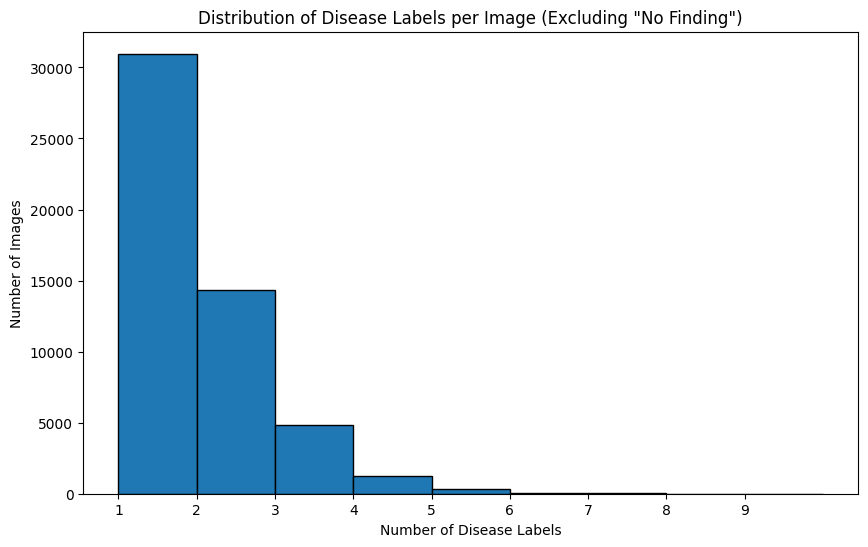

In [ ]:
# Plot histogram of 'Num Labels'
plt.figure(figsize=(10,6))
plt.hist(df['Num Labels'], bins=range(1, df['Num Labels'].max() + 2), edgecolor='black')
plt.title('Distribution of Disease Labels per Image (Excluding "No Finding")')
plt.xlabel('Number of Disease Labels')
plt.ylabel('Number of Images')
plt.xticks(range(1, df['Num Labels'].max() + 1))
plt.show()

We can see on this graph that most x-rays have one diagnosis, but some can have up to 6 diseases. As we have no prior knowledge on whether this is really happening in some cases, we did not discuss the possibility that this was an error.

Number of valid entries: 51759


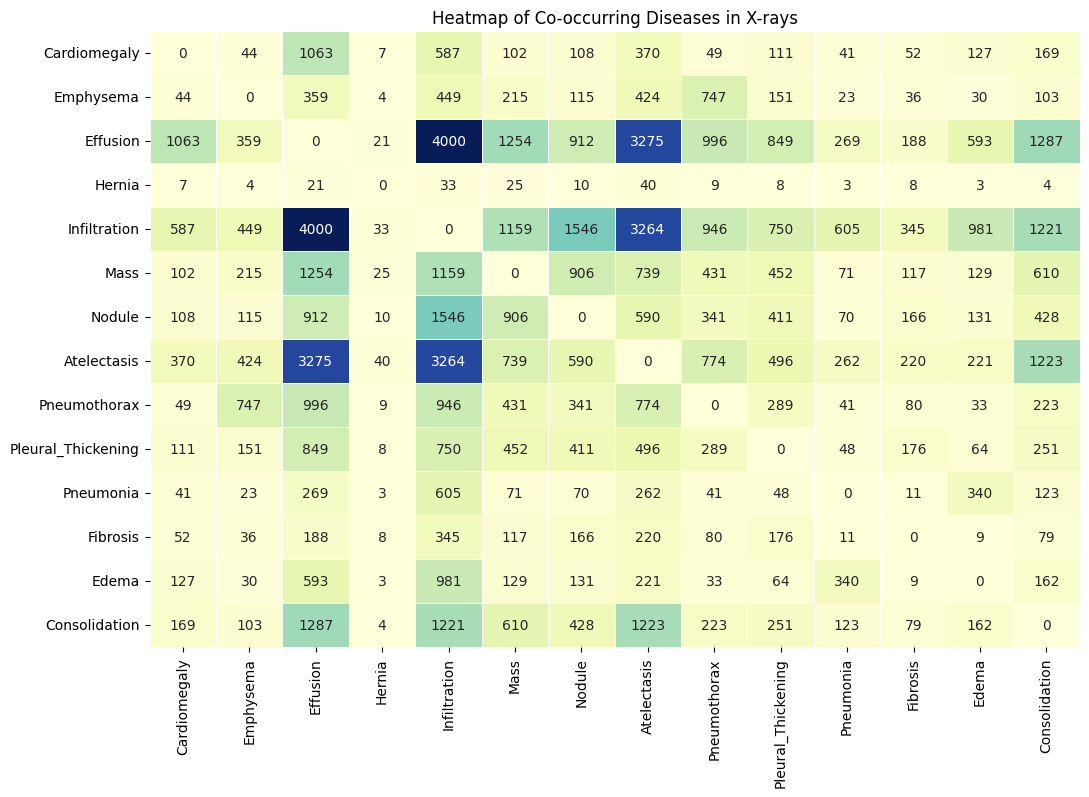

In [ ]:
df = pd.read_csv(csv_path_labels)

# Filter out rows with NaN or 'No Finding' labels
df = df[df['Finding Labels'].notna()]
df = df[df['Finding Labels'] != 'No Finding']

# Ensure 'Finding Labels' is treated as a string and then split
df['Finding Labels'] = df['Finding Labels'].astype(str).str.split('|')

# Generate pairwise combinations of labels for each image
label_combinations = []
for labels in df['Finding Labels']:
    label_combinations.extend(combinations(sorted(labels), 2))  # Sorted ensures no duplicates (A,B) and (B,A)

# Count the frequency of each label pair
pair_counts = pd.Series(label_combinations).value_counts()

# Create a DataFrame for the heatmap
pair_df = pd.DataFrame(0, index=df['Finding Labels'].apply(sorted).explode().unique(), columns=df['Finding Labels'].apply(sorted).explode().unique())

# Fill the DataFrame with pairwise counts
for (label1, label2), count in pair_counts.items():
    pair_df.loc[label1, label2] = count
    pair_df.loc[label2, label1] = count  # Since it's symmetric

# Plot the heatmap
print(f"Number of valid entries: {len(df)}")
plt.figure(figsize=(12, 8))
sns.heatmap(pair_df, annot=True, fmt='d', cmap="YlGnBu", cbar=False, linewidths=0.5)
plt.title("Heatmap of Co-occurring Diseases in X-rays")
plt.show()

### Dataset Label Calibration

In this section we updated label attributions, and made comparison between NLP extracted labels and experts' diagnosis.

Five American Board of Radiology certified radiologists independently reviewed the 810 images from the dataset, and classified the images into normal/abnormal. If the image were identified as abnormal, then, they classified it into one of the 14 classes of diseases.

Zaid Nabulsi, Andrew Sellergren, Shahar Jamshy, Charles Lau, Eddie Santos, Atilla P. Kiraly, Wenxing Ye, Jie Yang, Sahar Kazemzadeh, Jin Yu, Raju Kalidindi, Mozziyar Etemadi, Florencia Garcia Vicente, David Melnick, Greg S. Corrado, Lily Peng, Krish Eswaran, Daniel Tse, Neeral Beladia, Yun Liu, Po-Hsuan Cameron Chen, Shravya Shetty, Deep Learning for Distinguishing Normal versus Abnormal Chest Radiographs and Generalization to Two Unseen Diseases Tuberculosis and COVID-19, Scientific Reports, 2021. https://doi.org/10.1038/s41598-021-93967-2

The two csv files are available through this link: https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest#additional_labels

The first file (test_individual_readers.csv) contains the diagnosis of each individual doctor. Per patient/X-ray, there are 5 doctor's diagnosis. For some x-rays, it mentioned that they coudn't reach a consensus on the diagnosis, therefore, some of the images reviewed by the doctors are not included in the database.
The second file (all_findings_expert_label_test.csv) contains the consensus reached by the doctors. Each row contains the ground truth labels for a single image ID, and each image ID only appears in a single row, for a total of 810 rows. test_labels.csv has the same columns as test_individual_readers.csv, but without a "reader ID" column. To obtain these labels, three of the five radiologists who labeled this set were chosen at random to be the "ground truth radiologists" (the other two were used as points of comparison). These "ground truth radiologists" have reader IDs of "4343882785", "4343883593", and "4343883996". A majority vote was used to determine the final label for the normal/abnormal label and the final label for each particular finding. The final label for the Other column was determined to be YES if a majority of radiologists selected that a finding outside of the 14 was present, or if a majority of radiologists indicated that the image was abnormal, but no single finding had a majority of radiologists indicate was present. (Explanation extracted from the link provided above).

In this part we will focus on considering the level of correlation between the doctor's diagnosis and the NLP extracted labels.

In [ ]:
csv_path_expert_labels = r'/content/drive/MyDrive/project/all_findings_expert_labels_test_labels.csv'
csv_path_individ_diagn = r'/content/drive/MyDrive/project/test_individual_readers.csv'
df = pd.read_csv(csv_path_expert_labels)

# Extract and print the list of files (indexes) from the CSV
image_list = sorted(df.iloc[:, 0].astype(str).tolist())
print(len(image_list))

810


In [ ]:
# Load the CSV files of the experts' diagnosis and the NLP extracted diagnosis
partial_df = pd.read_csv(csv_path_expert_labels)
entire_df = pd.read_csv(csv_path_labels)

# Normalize column names for easier comparison
partial_df.columns = partial_df.columns.str.strip().str.replace(' ', '_')
entire_df.columns = entire_df.columns.str.strip().str.replace(' ', '_')

# Create lists to track results
match_results = []
mismatch_results = []
partial_match_result = []
# Iterate through partial database
for _, partial_row in partial_df.iterrows():
    image_id = partial_row['Image_ID']

    # Find the corresponding row in complete database
    entire_row = entire_df[entire_df['Image_Index'] == image_id]

    if not entire_row.empty:
        labels = entire_row['Finding_Labels'].values[0].split('|')

        if 'No Finding' in labels:
            # Check for no disease case
            if partial_row['Abnormal'] == 'NO':
                match_results.append([image_id, 'No Disease', 'No Finding'])
            else:
                mismatch_results.append([image_id, 'Marked Abnormal (Partial)', 'No Finding'])
        else:
            # Identify diseases marked as 'YES' in the partial dataset
            partial_diseases = [col for col in partial_df.columns[3:18] if partial_row[col] == 'YES']

            # Compare the two sets of labels
            if set(partial_diseases) == set(labels):
                match_results.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])
            elif set(partial_diseases) & set(labels):  # Check for intersection
                partial_match_result.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])
            else:
                mismatch_results.append([image_id, ', '.join(partial_diseases), ', '.join(labels)])

# Create DataFrames for results
match_df = pd.DataFrame(match_results, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])
partial_match_df = pd.DataFrame(partial_match_result, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])
mismatch_df = pd.DataFrame(mismatch_results, columns=['Image_ID', 'Partial_Diseases', 'Entire_Diseases'])

# Print results to console
print(f"Matches Found: {len(match_results)}")
print(f"Incomplete Match Results Found: {len(partial_match_result)}")
print(f"Mismatches Found: {len(mismatch_results)}")

Matches Found: 214
Incomplete Match Results Found: 249
Mismatches Found: 347


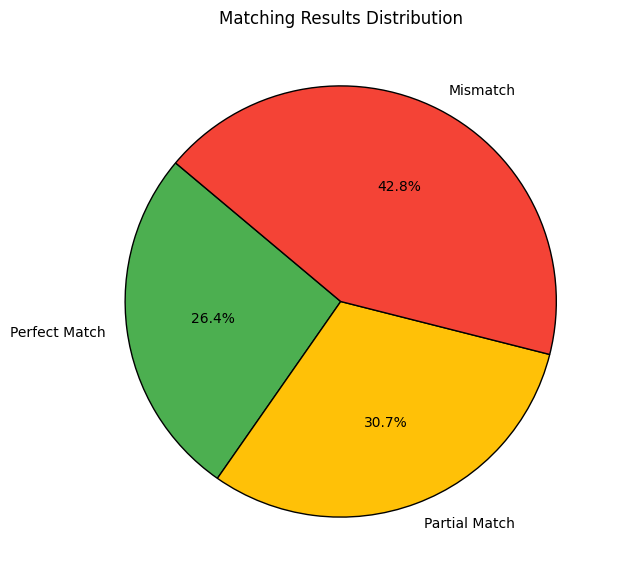

In [ ]:
# Labels and values
labels = ['Perfect Match', 'Partial Match', 'Mismatch']
sizes = [len(match_results), len(partial_match_result), len(mismatch_results)]
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Matching Results Distribution")

# Show plot
plt.show()

We can see that the correlation between the NLP extracted dataset and the expert's dataset has almost 50% of mismatch.

### Database containing the observation of each expert
Check on how much the experts were agreeing, verification on whether there was a lot of disagreement amongst doctors.

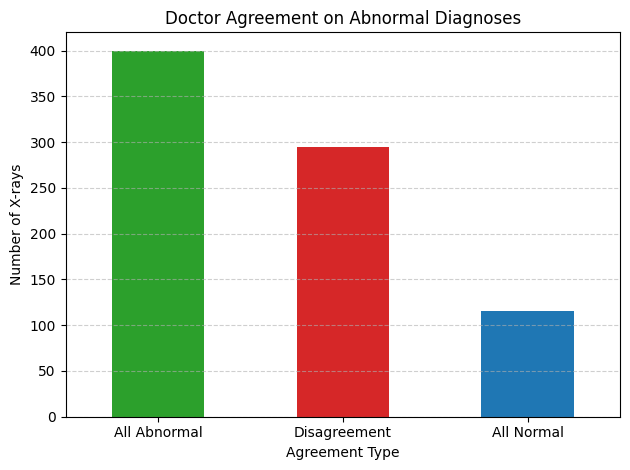

In [ ]:
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)
# Group by image and count abnormal votes
grouped = df_individ_diagn.groupby("Image ID")["Abnormal"].agg(["sum", "count"])
grouped["agreement_type"] = grouped["sum"].apply(
    lambda x: "All Abnormal" if x == 5 else ("All Normal" if x == 0 else "Disagreement")
)

# Count each category
agreement_counts = grouped["agreement_type"].value_counts()

# Plot
agreement_counts.plot(kind="bar", color=["#2ca02c", "#d62728", "#1f77b4"])
plt.title("Doctor Agreement on Abnormal Diagnoses")
plt.xlabel("Agreement Type")
plt.ylabel("Number of X-rays")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

All Abnormal: All five doctors agreed that the X-ray was abnormal.

All Normal: All five doctors agreed that the X-ray was normal.

Disagreement: The doctors did not reach a unanimous decision (i.e., some said abnormal while others said normal).

As we can see, there was a considerable amount of disagreement between doctors to identify whether the x-ray showed that the patient was healthy or had a abnormality.

Now let's compare if among their disease diagnosis there was also many disagreement.**bold text**

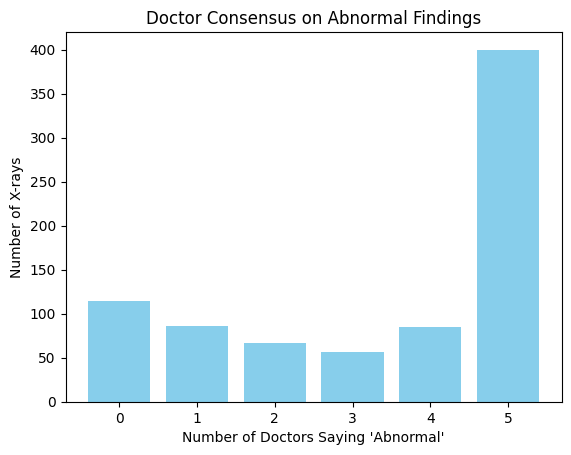

Number of X-rays with disagreement: 295
Abnormal
0    115
1     86
2     67
3     57
4     85
5    400
Name: count, dtype: int64


In [ ]:
# Load the dataset
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)

abnormal_counts = df_individ_diagn.groupby('Image ID')['Abnormal'].sum()
df_individ_diagn['Abnormal'] = df_individ_diagn['Abnormal'].map({'NO': 0, 'YES': 1})
consensus_distribution = abnormal_counts.value_counts().sort_index()
plt.bar(consensus_distribution.index, consensus_distribution.values, color='skyblue')
plt.xlabel("Number of Doctors Saying 'Abnormal'")
plt.ylabel("Number of X-rays")
plt.title("Doctor Consensus on Abnormal Findings")
plt.xticks(range(6))  # 0 to 5 doctors
plt.show()
disagreements = abnormal_counts[(abnormal_counts > 0) & (abnormal_counts < 5)]
print(f"Number of X-rays with disagreement: {len(disagreements)}")
print(abnormal_counts.value_counts().sort_index())

Full agreement:

0 = All doctors said normal.

5 = All doctors said abnormal.

Disagreement:

1–4 = Doctors were split (e.g., 3 said "abnormal," 2 said "normal").

Visulaization of the repartition between doctors on their position about the abnormality of the x-ray.

Average agreement per disease (for disputed X-rays):
Atelectasis: 0.45
Cardiomegaly: 0.12
Effusion: 0.33
Infiltration: 0.12
Mass: 0.17
Nodule: 0.22
Pneumonia: 0.02
Pneumothorax: 0.20
Consolidation: 0.31
Edema: 0.08
Emphysema: 0.05
Fibrosis: 0.05
Pleural Thickening: 0.16
Hernia: 0.01
Other: 0.08


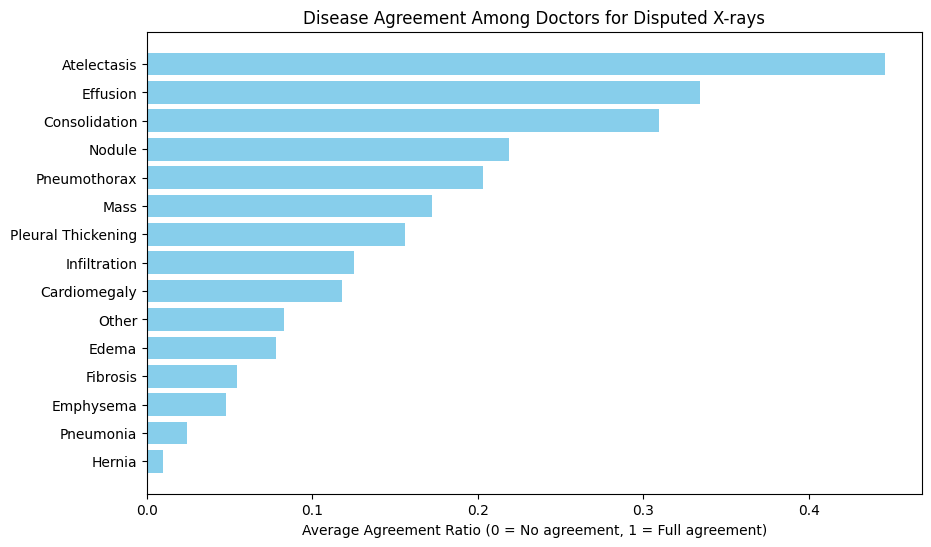

In [ ]:
# Load data
df_individ_diagn = pd.read_csv(csv_path_individ_diagn)

# Convert "NO"/"YES" to 0/1 for all disease columns
disease_columns = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema",
    "Fibrosis", "Pleural Thickening", "Hernia", "Other"  # Note the space here
]
for col in disease_columns:
    df_individ_diagn[col] = df_individ_diagn[col].map({"NO": 0, "YES": 1})
abnormal_counts = df_individ_diagn.groupby("Image ID")["Abnormal"].sum()
disputed_images = abnormal_counts[abnormal_counts >= 2].index
df_disputed = df_individ_diagn[df_individ_diagn["Image ID"].isin(disputed_images)]
# Store agreement statistics
disease_agreement = defaultdict(list)

for image_id in disputed_images:
    # Get all diagnoses for this X-ray
    diagnoses = df_disputed[df_disputed["Image ID"] == image_id][disease_columns]

    # Calculate pairwise agreement between doctors for each disease
    for disease in disease_columns:
        n_yes = diagnoses[disease].sum()  # Number of doctors who said "YES"
        total_doctors = len(diagnoses)
        disease_agreement[disease].append(n_yes / total_doctors)  # Agreement ratio (0 to 1)
avg_agreement = {disease: sum(ratios) / len(ratios) for disease, ratios in disease_agreement.items()}
print("Average agreement per disease (for disputed X-rays):")
for disease, agreement in avg_agreement.items():
    print(f"{disease}: {agreement:.2f}")
# Sort diseases by agreement (ascending)
sorted_agreement = sorted(avg_agreement.items(), key=lambda x: x[1])

# Extract labels and values for plotting
diseases, agreements = zip(*sorted_agreement)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(diseases, agreements, color="skyblue")
plt.xlabel("Average Agreement Ratio (0 = No agreement, 1 = Full agreement)")
plt.title("Disease Agreement Among Doctors for Disputed X-rays")
plt.show()

That plot shows an important insight: when doctors agree that an X-ray is abnormal, they rarely agree on the specific disease labels. Out of all cases where all five doctors marked an image as "abnormal," only a small fraction had full agreement on the exact diseases present.

This highlights the subjectivity and variability in expert annotations, which is critical when training models on medical data.

At first, if these 'ground truth' labels were reliable we were considering keeping the images specifically in our sampling and keeping the labels given by the consensus of doctors. We also considered having a CNN trained on this subdataset, and then testing it on the broader dataset to see if we could create the 'ground truth'. But as this subset dataset is very small (810 images), it probably would not work very well and we would not be able to verify the output of the model.

But as the outcome of the analysis of this subdataset shows, there is a very high variation between diagnosis by doctors. There have been studies showing that deep learning model show higher accuracy than radiologists when interpreting chest X-rays.

  1- Guo, L., Zhou, C., Xu, J. et al. Deep Learning for Chest X-ray Diagnosis: Competition Between Radiologists with or Without Artificial Intelligence Assistance. J Digit Imaging. Inform. med. 37, 922–934 (2024). https://doi.org/10.1007/s10278-024-00990-6

  2 - Anderson, P.G., Tarder-Stoll, H., Alpaslan, M. et al. Deep learning improves physician accuracy in the comprehensive detection of abnormalities on chest X-rays. Sci Rep 14, 25151 (2024). https://doi.org/10.1038/s41598-024-76608-2


Therefore, we decided to continue using the noisy labeled dataset, as it would be very hard for us to establish a ground truth. And such a topic may also be beyond the scope of this module.

## Preprocessing and Data Analysis

In [ ]:
# General Functions Definitions
def get_label_distribution(subset_df):
    all_labels = [label for labels in subset_df['Finding Labels'] for label in labels]
    return Counter(all_labels)

def get_all_image_paths(root_dir):
    """
    Scans all `images_*/images/*.png` subfolders and returns a dictionary
    mapping image filename to full path.
    """
    image_dict = {}
    # Match all folders like images_001, images_002, ..., images_012
    folders = glob(os.path.join(root_dir, 'images_*', 'images'))

    for folder in folders:
        all_images = glob(os.path.join(folder, '*.png'))
        for path in all_images:
            name = os.path.basename(path)
            image_dict[name] = path

    return image_dict

def plot_class_balance(train_df, test_df):
    # Get label distributions
    train_counts = get_label_distribution(train_df)
    test_counts = get_label_distribution(test_df)

    # Combine into a DataFrame for seaborn
    all_labels = sorted(set(train_counts.keys()).union(test_counts.keys()))
    data = {
        'Class': all_labels,
        'Train': [train_counts.get(label, 0) for label in all_labels],
        'Test': [test_counts.get(label, 0) for label in all_labels],
    }
    balance_df = pd.DataFrame(data)

    # Melt for seaborn
    melt_df = pd.melt(balance_df, id_vars='Class', value_vars=['Train', 'Test'],
                      var_name='Dataset', value_name='Image Count')

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=melt_df, x='Class', y='Image Count', hue='Dataset')
    plt.title('Class Balance in Train vs Test Sets')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Balanced disease first splitting of the dataset

We firstly decided to split our data in such a way:

Training set: **20000**
Test set: **10000**

We resized our images into 256x256 size.

The function balanced_multi_split does a splitting of the x-rays images into training and test sets, while ensuring that:

* Rare conditions get represented: It prioritizes including images with less common medical findings first, so they don't get left out.

* There is no data leakage: Each image appears in only one set (train or test), never both.

* For each medical condition found in the images, it distributes ~80% of those cases to training and ~20% to test (while respecting the total sizes you requested).

* It understands that each image can have multiple medical conditions simultaneously (multilabel), and makes sure all conditions get fair representation.

It starts with the rarest medical conditions first to guarantee they're included, maintains roughly the same ratio of conditions in both train and test sets. It stops once either the train or test set reaches your requested size and it uses randomness (with a fixed seed for reproducibility) when needed.

Output:

Image IDs for training (up to train_size items)

Image IDs for testing (up to test_size items)


In [ ]:
def balanced_multilabel_split(df, train_size=20000, test_size=10000, seed=42):
    random.seed(seed)

    # Convert string labels to list
    if isinstance(df['Finding Labels'].iloc[0], str):
        df['Finding Labels'] = df['Finding Labels'].str.split('|')

    # Count label frequencies
    label_counter = Counter(label for labels in df['Finding Labels'] for label in labels)
    sorted_labels = sorted(label_counter.items(), key=lambda x: x[1])  # rarest first

    # Build mapping
    image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
    label_to_images = defaultdict(set)
    for img, labels in image_labels.items():
        for label in labels:
            label_to_images[label].add(img)

    # Sets to track assignment
    train_images = set()
    test_images = set()
    used_images = set()

    def add_image(img, to_train):
        target_set = train_images if to_train else test_images
        if img not in used_images:
            target_set.add(img)
            used_images.add(img)

    for label, _ in sorted_labels:
        candidate_images = list(label_to_images[label] - used_images)
        random.shuffle(candidate_images)

        n_total = len(candidate_images)

        # Skip if we've hit capacity
        if len(train_images) >= train_size and len(test_images) >= test_size:
            break

        # If we still need space, figure out how many to allocate
        remaining_train = train_size - len(train_images)
        remaining_test = test_size - len(test_images)
        available = min(n_total, remaining_train + remaining_test)

        if available == 0:
            continue

        n_train = int(available * 0.8)
        n_test = available - n_train

        # Adjust to stay within global limits
        n_train = min(n_train, remaining_train)
        n_test = min(n_test, remaining_test)

        # Assign images
        for img in candidate_images[:n_train]:
            add_image(img, to_train=True)
        for img in candidate_images[n_train:n_train + n_test]:
            add_image(img, to_train=False)

    return list(train_images), list(test_images)

The custom Dataset returns a tuple containing:
* The transformed image tensor
* List of medical findings (e.g., ["Atelectasis", "Effusion"])
* Age of patient


In [ ]:
class NIHDataset_modified(Dataset):
    def __init__(self, df, root_dir, sizeimagesout):
        self.sizeimagesout = sizeimagesout
        self.root_dir = root_dir
        df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|') if isinstance(x, str) else x)
        image_dict = get_all_image_paths(root_dir)

        self.image_names = [name for name in df['Image Index'] if name in image_dict]
        self.image_paths = [image_dict[name] for name in self.image_names]
        self.labels = df.set_index('Image Index').loc[self.image_names]['Finding Labels'].tolist()
        self.ages = df.set_index('Image Index').loc[self.image_names]['Patient Age'].tolist()
        self.transform = T.Compose([
                                      #transforms.RandomRotation(fnd(), expand=True),
                                      T.RandomRotation(10, expand=True),
                                      T.Resize(self.sizeimagesout),
                                      T.RandomHorizontalFlip(),
                                      T.RandomVerticalFlip(),
                                      #transforms.ColorJitter(0.01),
                                      #transforms.RandomAffine(10),
                                      T.ToTensor()
                                     ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path)
        img = self.transform(img)
        return img, self.labels[index], self.ages[index]

Train label distribution:
Counter({'Mass': 4610, 'Infiltration': 4566, 'Effusion': 4278, 'Pneumothorax': 4235, 'Consolidation': 3746, 'Atelectasis': 3010, 'Pleural_Thickening': 2712, 'Cardiomegaly': 2213, 'Emphysema': 2016, 'Edema': 1843, 'Nodule': 1727, 'Fibrosis': 1349, 'Pneumonia': 1144, 'Hernia': 181})

Test label distribution:
Counter({'Infiltration': 2239, 'Effusion': 2194, 'Atelectasis': 1859, 'Nodule': 1359, 'Mass': 1169, 'Pneumothorax': 1066, 'Consolidation': 921, 'Pleural_Thickening': 672, 'Cardiomegaly': 563, 'Emphysema': 500, 'Edema': 459, 'No Finding': 426, 'Fibrosis': 337, 'Pneumonia': 286, 'Hernia': 46})


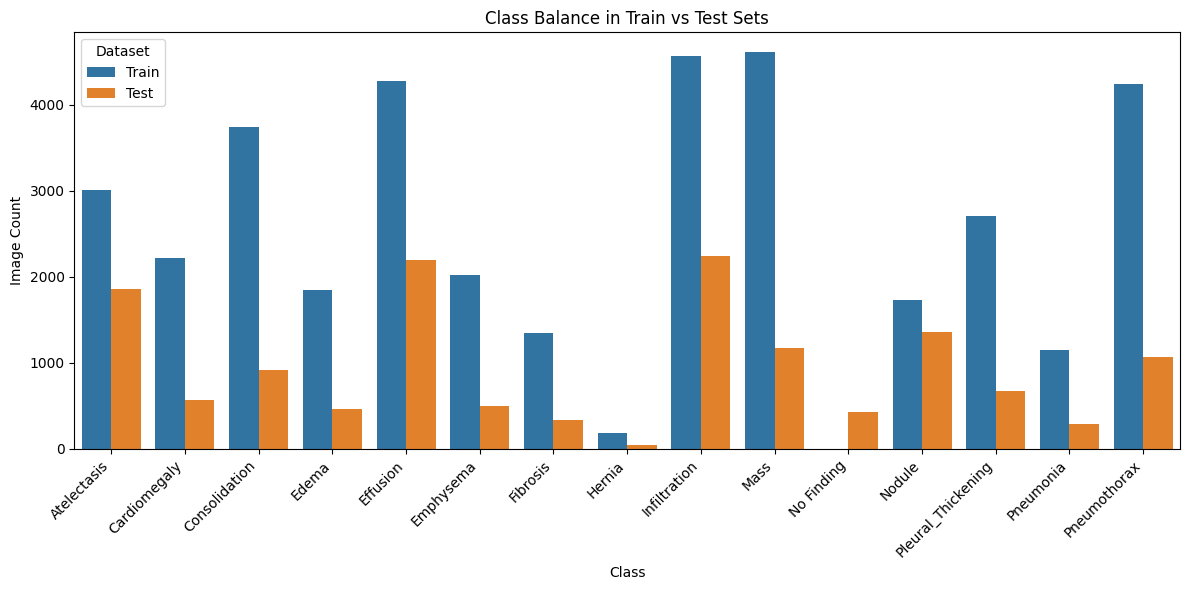

In [ ]:
df = pd.read_csv(csv_path_labels)
df = df[df['Patient Age'] <= 100].reset_index(drop=True)
df['Finding Labels'] = df['Finding Labels'].str.split('|')

root_dir = 'C:/Users/e1498134/Documents/Courses/CS5242/Project'
size_out = (256, 256)

## Dataset constitution:
# training set = 20000
# test set ~ 8000
# includes the age in the data (img, label[], age)
train_ids, test_ids = balanced_multilabel_split(df, train_size=20000, test_size=10000)

train_df = df[df['Image Index'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['Image Index'].isin(test_ids)].reset_index(drop=True)

train_dataset = NIHDataset_modified(train_df, root_dir, size_out)
test_dataset = NIHDataset_modified(test_df, root_dir, size_out)

print("Train label distribution:")
print(get_label_distribution(train_df))
print("\nTest label distribution:")
print(get_label_distribution(test_df))
plot_class_balance(train_df, test_df)

With this splitting technique as we needed to take the diseases first we did not have a balanced representation of the "No Finding". Therefore we rectified it with some data augmentation approaches listed in the next section.

### Binary disease splitting of the dataset

We constituated a binary labeled dataset (complete dataset) for Transformer:

Label ∈ (Normal, Abnormal)

The function binary_balanced_split creates balanced training and test sets for binary classification  by first ensuring equal numbers of normal and abnormal cases, then splitting each group while maintaining the specified train-test ratio. It handles NIH chest X-ray data specifically by managing multi-label annotations and guaranteeing balanced class distribution in both sets

In [ ]:
def binary_balanced_split(df, train_ratio=0.8, seed=42):
    """
    Manually split a balanced dataset into train and test.
    Returns train_df and test_df.
    """
    random.seed(seed)

    # Ensure 'binary_label' column exists
    if 'binary_label' not in df.columns:
        df['binary_label'] = df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)

    # Separate into normal and abnormal
    df_normal = df[df['binary_label'] == 0].copy()
    df_abnormal = df[df['binary_label'] == 1].copy()

    # Match dataset sizes by downsampling the larger group
    min_size = min(len(df_normal), len(df_abnormal))
    df_normal = df_normal.sample(min_size, random_state=seed)
    df_abnormal = df_abnormal.sample(min_size, random_state=seed)

    # Shuffle both
    df_normal = df_normal.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_abnormal = df_abnormal.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Calculate split indices
    n_train = int(train_ratio * min_size)

    # Split each group
    train_normal = df_normal.iloc[:n_train]
    test_normal = df_normal.iloc[n_train:]

    train_abnormal = df_abnormal.iloc[:n_train]
    test_abnormal = df_abnormal.iloc[n_train:]

    # Combine splits
    train_df = pd.concat([train_normal, train_abnormal]).sample(frac=1, random_state=seed).reset_index(drop=True)
    test_df = pd.concat([test_normal, test_abnormal]).sample(frac=1, random_state=seed).reset_index(drop=True)

    return train_df, test_df

This class loads and preprocesses NIH chest X-ray images for binary classification , automatically converting multi-label findings into binary labels while preserving patient age information. It efficiently handles image paths, filters missing files, and resizes images to a specified dimension, returning tuples of (image, binary_label, age) for model training.



In [ ]:
class NIHBinaryDataset(Dataset):
    def __init__(self, df, root_dir, sizeimagesout):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.sizeimagesout = sizeimagesout

        # Make sure label is binary
        if 'binary_label' not in self.df.columns:
            self.df['binary_label'] = self.df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)

        # Map images to full paths
        self.image_paths = get_all_image_paths(root_dir)  # This should return {filename: full_path}
        self.df = self.df[self.df['Image Index'].isin(self.image_paths.keys())]

        # Filter image paths accordingly
        self.df['full_path'] = self.df['Image Index'].map(self.image_paths)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row['full_path']).convert("RGB")
        image = T.Resize(self.sizeimagesout)(image)
        label = row['binary_label']
        age = row['Patient Age']

        return image, label, age

Train set: 82800 (Normal: 41400, Abnormal: 41400)
Test set: 20702 (Normal: 10351, Abnormal: 10351)


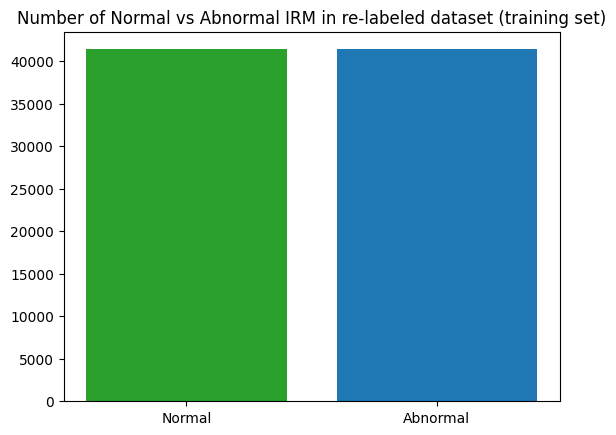

In [ ]:
train_df_binary, test_df_binary = binary_balanced_split(df)
train_dataset = NIHBinaryDataset(train_df_binary, root_dir,size_out)
test_dataset = NIHBinaryDataset(test_df_binary, root_dir, size_out)

print(f"Train set: {len(train_df_binary)} (Normal: {sum(train_df_binary['binary_label']==0)}, Abnormal: {sum(train_df_binary['binary_label']==1)})")
print(f"Test set: {len(test_df_binary)} (Normal: {sum(test_df_binary['binary_label']==0)}, Abnormal: {sum(test_df_binary['binary_label']==1)})")
fig, ax = plt.subplots()

states = ['Normal', 'Abnormal']
counts = [sum(train_df_binary['binary_label']==0), sum(train_df_binary['binary_label']==1)]
bar_labels = ['green', 'blue']
bar_colors = ['tab:green', 'tab:blue']

ax.bar(states, counts, label=bar_labels, color=bar_colors)

ax.set_title('Number of Normal vs Abnormal IRM in re-labeled dataset (training set)')

plt.show()


## Data Augmentation and Metrics

### Sampling Strategies

As we noticed that the data skewed heavily, we decided to use some sampling strategies to balance the dataset. The method we took included:

1. **Original distribution sampling**: leveraging the multi-label stratified shuffle split functions provided by `iterstrat` library, we directly sampled the original distribution of the dataset. This sampling strategy is mainly used for verifying whether the skewed dataset will affect the model performance.

2. **Round-robin sampling**: we sampled one instance from each label in a round-robin fashion until we reach the desired number of samples. When the number of samples of one label is expired, we will skip this label and continue sampling from the remaining labels. We used this method to try to sample the data samples as balanced as possible.

3. **Rare-first sampling**: this method is used to sample the labels from the dataset in a rare-first manner. This means that we will sample the rarest label first. As the "No Finding" label samples take roughly 50% of the dataset, and belonged samples actually may not help the model to learn so much. Through this method, we hope the model can pay more attention to the rare labels.

4. **Binary sampling**: as we want to leverage the generative models to do abnormality detection, we relabeled the dataset to binary labels. The samples with "No Finding" label are relabeled to 0, and the samples with other labels are relabeled to 1. This method is used to verify whether the generative models can learn the distribution of the normal samples.

We trained the models with the above sampling strategies and evaluated the performance of the models on the test set, to compare the performance of different kinds of deep learning models, and how will the sampling strategies affect the model performance. The different sampling strategies also served as a data augmentation method to increase the diversity of the training set in our project.

For each sampling strategy, the dataset is split into 80% for training (20k samples), 10% for validation (2.5k samples), and 10% for testing (2.5k samples). The training set is used to train the model, the validation set is used to avoid overfitting and trigger early stopping, and the test set is used to evaluate the model performance.

Here we utilized the following visualization function to show the relative distribution of the labels in the preprocessed dataset under different sampling strategies.

In [ ]:
import os
import os.path as osp
import random
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

%matplotlib inline

def show_split_distribution(train_df, val_df, test_df, original_df=None, save_name=None):
    """
    Visualizes the relative percentage distribution of labels across train, validation and test sets.
    """
    # Function to count labels in a dataframe
    def count_labels(df):
        label_counts = defaultdict(int)
        for labels in df['Finding Labels']:
            for label in labels:
                label_counts[label] += 1
        return label_counts
    # Count labels in each split
    train_counts = count_labels(train_df)
    val_counts = count_labels(val_df)
    test_counts = count_labels(test_df)
    # If original dataset is provided, count those labels too
    if original_df is not None:
        # Ensure 'Finding Labels' are lists
        if isinstance(original_df["Finding Labels"].iloc[0], str):
            orig_df_copy = original_df.copy()
            orig_df_copy["Finding Labels"] = orig_df_copy["Finding Labels"].str.split('|')
        else:
            orig_df_copy = original_df
        orig_counts = count_labels(orig_df_copy)
    # Get all unique labels
    all_labels = set()
    for counts in [train_counts, val_counts, test_counts]:
        all_labels.update(counts.keys())
    all_labels = sorted(list(all_labels))
    # Prepare data for plotting
    train_values = [train_counts.get(label, 0) for label in all_labels]
    val_values = [val_counts.get(label, 0) for label in all_labels]
    test_values = [test_counts.get(label, 0) for label in all_labels]
    # Calculate percentages
    train_size = sum(train_values)
    val_size = sum(val_values)
    test_size = sum(test_values)
    train_pct = [count/train_size*100 for count in train_values]
    val_pct = [count/val_size*100 for count in val_values]
    test_pct = [count/test_size*100 for count in test_values]
    # For original dataset if provided
    if original_df is not None:
        orig_values = [orig_counts.get(label, 0) for label in all_labels]
        orig_size = sum(orig_values)
        orig_pct = [count/orig_size*100 for count in orig_values]
    # Setup for plot
    plt.figure(figsize=(15, 6))
    x = np.arange(len(all_labels))
    width = 0.2
    plt.bar(x - width*1.5, train_pct, width, label='Train')
    plt.bar(x - width/2, val_pct, width, label='Validation')
    plt.bar(x + width/2, test_pct, width, label='Test')
    if original_df is not None:
        plt.bar(x + width*1.5, orig_pct, width, label='Original')
    plt.ylabel('Percentage (%)')
    plt.title('Relative Label Distribution')
    plt.xticks(x, all_labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    if save_name:
        save_dir = "imgs"
        if not osp.exists(save_dir):
            os.makedirs(save_dir)
        save_path = osp.join(save_dir, save_name)
        plt.savefig(save_path)
    else:
        plt.show()
    # Print summary statistics
    print("Dataset sizes:")
    print(f"Train: {len(train_df)} samples with {sum(train_values)} labels (avg {sum(train_values)/len(train_df):.2f} labels per sample)")
    print(f"Validation: {len(val_df)} samples with {sum(val_values)} labels (avg {sum(val_values)/len(val_df):.2f} labels per sample)")
    print(f"Test: {len(test_df)} samples with {sum(test_values)} labels (avg {sum(test_values)/len(test_df):.2f} labels per sample)")
    if original_df is not None:
        print(f"Original: {len(original_df)} samples with {sum(orig_values)} labels (avg {sum(orig_values)/len(original_df):.2f} labels per sample)")


### Original Distribution Sampling

To implement the original distribution sampling, we used the `MultiLabelStratifiedShuffleSplit` function from the `iterstrat` library. This function allows us to split the dataset into training, validation, and test sets while preserving the original label distribution.

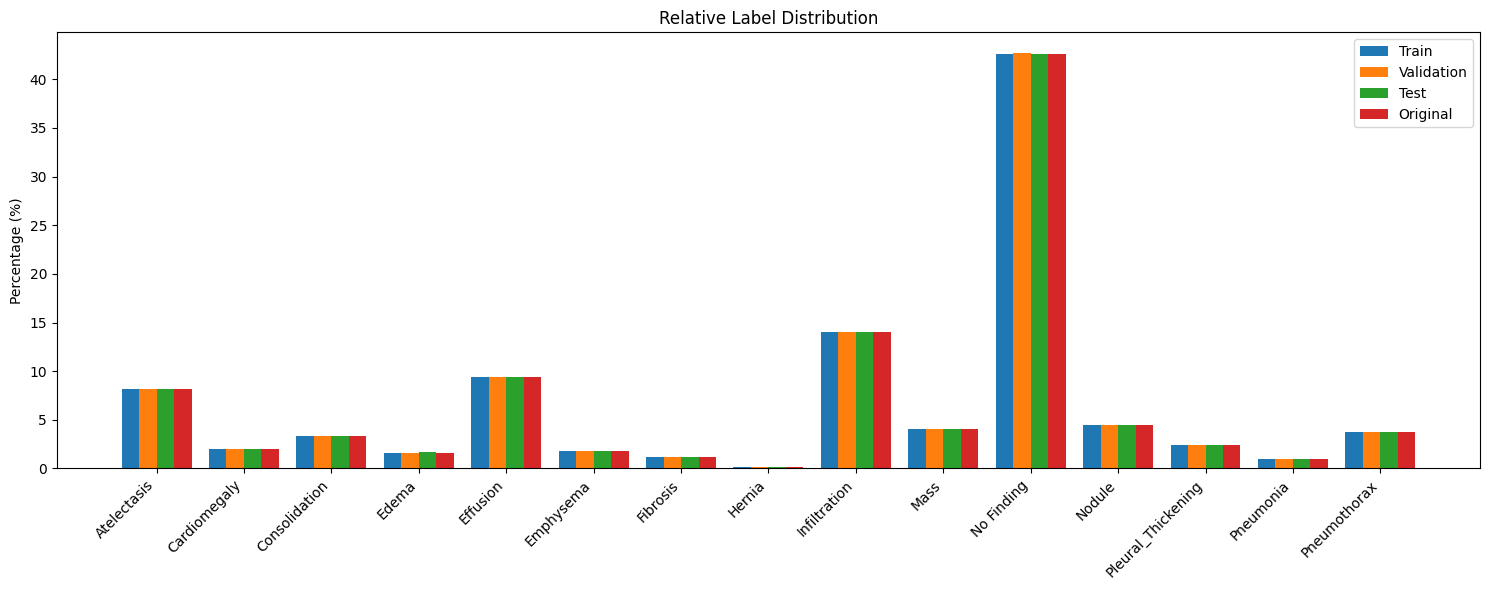

Dataset sizes:
Train: 19989 samples with 25249 labels (avg 1.26 labels per sample)
Validation: 2516 samples with 3153 labels (avg 1.25 labels per sample)
Test: 2505 samples with 3158 labels (avg 1.26 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [ ]:
def multilabel_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split("|")
    # Binarize the labels
    mlb = MultiLabelBinarizer()
    Y_full = mlb.fit_transform(df["Finding Labels"])   # (N, L)
    idx_full = df.index.to_numpy()
    total = len(df)
    subsz = train_size + val_size + test_size
    # Select a stratified subsample of the desired total size from the full dataset
    msss0 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=subsz / total,
        test_size=(total - subsz) / total,
        random_state=seed
    )
    sub_i, _ = next(msss0.split(idx_full, Y_full))
    df_sub = df.iloc[sub_i].reset_index(drop=True)
    Y_sub  = Y_full[sub_i]
    # Split the subsample into training and temporary (validation + test) sets
    msss1 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=train_size / subsz,
        test_size=(val_size + test_size) / subsz,
        random_state=seed
    )
    tr_i, tmp_i = next(msss1.split(df_sub.index.to_numpy(), Y_sub))
    df_train = df_sub.iloc[tr_i].reset_index(drop=True)
    df_tmp   = df_sub.iloc[tmp_i].reset_index(drop=True)
    Y_tmp    = Y_sub[tmp_i]
    # Split the temporary set into validation and test sets
    msss2 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=val_size / (val_size + test_size),
        test_size=test_size / (val_size + test_size),
        random_state=seed
    )
    v_i, te_i = next(msss2.split(df_tmp.index.to_numpy(), Y_tmp))
    df_val  = df_tmp.iloc[v_i].reset_index(drop=True)
    df_test = df_tmp.iloc[te_i].reset_index(drop=True)
    return df_train, df_val, df_test

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_split(df)
show_split_distribution(train_df, val_df, test_df, df)

From the figure above, we can see that the original distribution of the dataset is heavily skewed towards the "No Finding" label, which takes up about 50% of the dataset. The other labels are much less frequent, with some labels having only a few samples. Using the original distribution sampling strategy, all labels preserved their original distribution in the training, validation, and test sets.

### Round-Robin Sampling

To make the dataset more balanced, we implemented a round-robin sampling strategy. This method samples one instance from each label in a round-robin fashion until we reach the desired number of samples. The round-robin sampling strategy helps to ensure that each label is represented in the training set, even if some labels are rare. We implemented this strategy using the below code snippet.

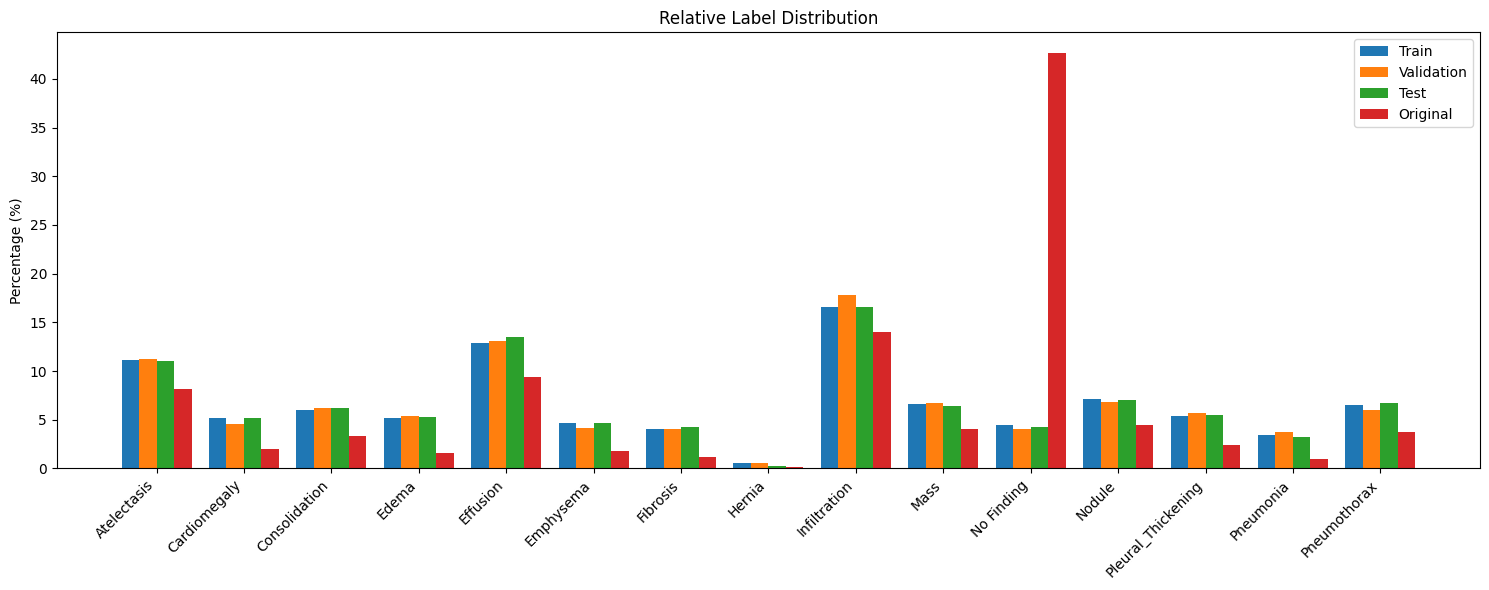

Dataset sizes:
Train: 20000 samples with 32886 labels (avg 1.64 labels per sample)
Validation: 2500 samples with 4222 labels (avg 1.69 labels per sample)
Test: 2500 samples with 4143 labels (avg 1.66 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [ ]:
def multilabel_balanced_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    """
    Splits a multilabel dataset into balanced training, validation, and test sets.

    This function attempts to ensure that each label is represented as evenly as possible across the splits,
    by iteratively sampling indices associated with each label until the desired split sizes are reached.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split('|')
    total_size = train_size + val_size + test_size
    # Construct a mapping of labels to their indices
    label2idxs = defaultdict(list)
    for idx, row in df.iterrows():
        for label in row['Finding Labels']:
            label2idxs[label].append(idx)
    labels = list(label2idxs.keys())
    # Records the index of the last sampled item for each label
    label_ptr = {l: 0 for l in labels}
    # Main sampling loop
    sampled_idx = set()
    last_sampled_count = 0
    cut_pos = []
    newly_sampled_idx = []
    total_idxs = set(range(len(df)))
    while len(sampled_idx) < total_size:
        for label in labels:
            ptr = label_ptr[label]
            total_label_idx = label2idxs[label]
            # Skip labels that have been fully traversed
            if ptr >= len(total_label_idx):
                continue
            while ptr < len(total_label_idx):
                xi = total_label_idx[ptr]
                ptr += 1
                if xi not in sampled_idx:
                    sampled_idx.add(xi)
                    newly_sampled_idx.append(xi)
                    break
            label_ptr[label] = ptr
        # Check if have exhausted all labels
        any_exhausted = False
        for l in labels:
            if label_ptr[l] >= len(label2idxs[l]):
                any_exhausted = True
                break
        if any_exhausted or len(sampled_idx) >= total_size:
            # Record the cut point
            cut_pos.append((last_sampled_count, len(sampled_idx)))
            last_sampled_count = len(sampled_idx)
    # Fill in the remaining samples
    remaining_needed = total_size - len(sampled_idx)
    if remaining_needed > 0:
        remain_pool = list(total_idxs - sampled_idx)
        random.shuffle(remain_pool)
        for xi in remain_pool[:remaining_needed]:
            sampled_idx.add(xi)
            newly_sampled_idx.append(xi)
        if remaining_needed > 0:
            cut_pos.append((last_sampled_count, len(sampled_idx)))
            last_sampled_count = len(sampled_idx)
    # Assign the sampled indices to the corresponding dataset
    sampled_idx_list = list(sampled_idx)
    random.shuffle(sampled_idx_list)
    train_ids = sampled_idx_list[:train_size]
    val_ids = sampled_idx_list[train_size: train_size + val_size]
    test_ids = sampled_idx_list[train_size + val_size: train_size + val_size + test_size]
    train_df = df.loc[train_ids].reset_index(drop=True)
    val_df = df.loc[val_ids].reset_index(drop=True)
    test_df = df.loc[test_ids].reset_index(drop=True)
    return train_df, val_df, test_df

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_balanced_split(df)
show_split_distribution(train_df, val_df, test_df, df)

Through this method, we can see that the distribution of the labels in the training set is much more balanced compared to the original distribution. The round-robin sampling strategy ensures that each label is represented in the training set, which can help the model learn better representations for all labels.

### Rare-First Sampling

As rare diseases are often overlooked, but important to detect, we implemented a rare-first sampling strategy. This method samples the rarest label first, ensuring that the model pays more attention to the rare labels. The rare-first sampling strategy is implemented using the below code snippet.

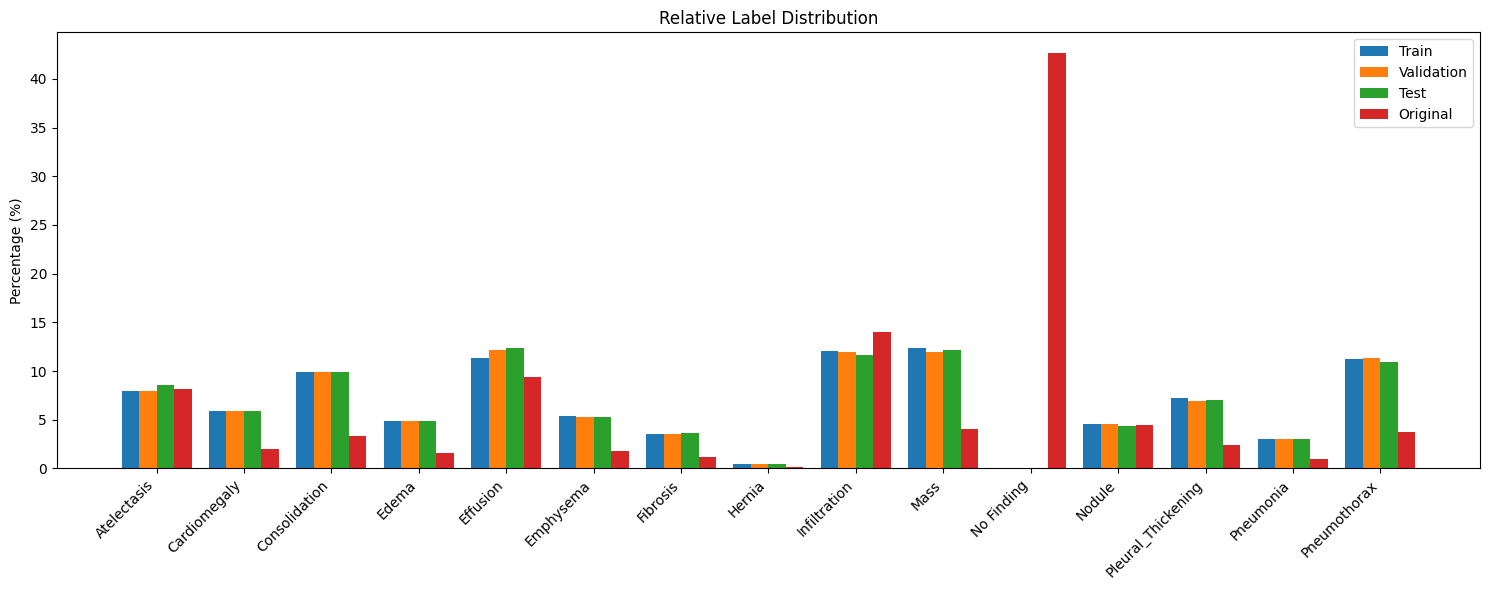

Dataset sizes:
Train: 20000 samples with 37641 labels (avg 1.88 labels per sample)
Validation: 2500 samples with 4684 labels (avg 1.87 labels per sample)
Test: 2500 samples with 4749 labels (avg 1.90 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [ ]:
def multilabel_rare_first_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    """
    Splits a multilabel dataset into train, validation, and test sets, prioritizing rare labels.

    This function ensures that images containing rare labels are assigned to splits first, 
    helping to maximize the representation of infrequent labels in all splits.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df['Finding Labels'].iloc[0], str):
        df['Finding Labels'] = df['Finding Labels'].str.split('|')
    # Count label frequencies
    label_counter = Counter(label for labels in df['Finding Labels'] for label in labels)
    sorted_labels = sorted(label_counter.items(), key=lambda x: x[1])  # rarest first
    # Build mapping
    image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
    label_to_images = defaultdict(set)
    for img, labels in image_labels.items():
        for label in labels:
            label_to_images[label].add(img)
    # Sets to track assignment
    train_images = set()
    val_images = set()
    test_images = set()
    used_images = set()
    def add_image(img, split):
        if img not in used_images:
            if split == "train":
                train_images.add(img)
            elif split == "val":
                val_images.add(img)
            elif split == "test":
                test_images.add(img)
            used_images.add(img)
    total_needed = train_size + val_size + test_size
    for label, _ in sorted_labels:
        candidate_images = list(label_to_images[label] - used_images)
        random.shuffle(candidate_images)
        n_total = len(candidate_images)
        # Skip if we've hit capacity
        if len(train_images) >= train_size and len(val_images) >= val_size and len(test_images) >= test_size:
            break
        remaining_train = train_size - len(train_images)
        remaining_val = val_size - len(val_images)
        remaining_test = test_size - len(test_images)
        available = min(n_total, remaining_train + remaining_val + remaining_test)
        if available == 0:
            continue
        n_train = int(available * (train_size / total_needed))
        n_val = int(available * (val_size / total_needed))
        n_test = available - n_train - n_val
        # Adjust to stay within global limits
        n_train = min(n_train, remaining_train)
        n_val = min(n_val, remaining_val)
        n_test = min(n_test, remaining_test)
        idx = 0
        for img in candidate_images[idx:idx + n_train]:
            add_image(img, "train")
        idx += n_train
        for img in candidate_images[idx:idx + n_val]:
            add_image(img, "val")
        idx += n_val
        for img in candidate_images[idx:idx + n_test]:
            add_image(img, "test")
    # If not enough images, fill randomly from unused
    all_images = set(df["Image Index"])
    unused_images = list(all_images - used_images)
    random.shuffle(unused_images)
    while len(train_images) < train_size and unused_images:
        add_image(unused_images.pop(), "train")
    while len(val_images) < val_size and unused_images:
        add_image(unused_images.pop(), "val")
    while len(test_images) < test_size and unused_images:
        add_image(unused_images.pop(), "test")
    # Build DataFrames
    train_df = df[df["Image Index"].isin(train_images)].reset_index(drop=True)
    val_df = df[df["Image Index"].isin(val_images)].reset_index(drop=True)
    test_df = df[df["Image Index"].isin(test_images)].reset_index(drop=True)
    return train_df, val_df, test_df

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_rare_first_split(df)
show_split_distribution(train_df, val_df, test_df, df)

As shown in the figure, the rare-first sampling strategy ensures that the rare labels are represented in the splits. However, the "No Finding" label is excluded, due to its high prevalence in the dataset. This sampling strategy can help the model learn better representations for the rare labels, which can be important for detecting rare diseases, while still allowing the dataset to be balanced.

### Binary Sampling

To leverage the generative models for abnormality detection, we relabeled the dataset to binary labels. The samples with "No Finding" label are relabeled to 0, and the samples with other labels are relabeled to 1. This method is used to verify whether the generative models can learn the distribution of the normal samples. As there are only two labels in the dataset, we did not provide the visualization for this sampling strategy.

For the size of the dataset, we still used 20k samples for training, to ensure that the comparison is fair across different deep learning models. And we used 2.5k normal samples and 2.5k abnormal samples for the testing.

In [ ]:
def binary_split(df, train_size=20000, test_normal_size=2500, test_abnormal_size=2500, seed=42):
    """
    Splits a DataFrame containing medical findings into training and test sets for binary classification.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split('|')
    # Ensure 'binary_label' column exists
    if 'binary_label' not in df.columns:
        df['binary_label'] = df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)
    # Separate into normal and abnormal
    df_normal = df[df['binary_label'] == 0].copy()
    df_abnormal = df[df['binary_label'] == 1].copy()
    # Shuffle both datasets
    df_normal = df_normal.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_abnormal = df_abnormal.sample(frac=1, random_state=seed).reset_index(drop=True)
    # Check if we have enough data
    if len(df_normal) < train_size:
        raise ValueError(f"Not enough normal samples: have {len(df_normal)}, need {train_size}")
    if len(df_abnormal) < (test_normal_size + test_abnormal_size):
        raise ValueError(f"Not enough abnormal samples: have {len(df_abnormal)}, need {test_normal_size, test_abnormal_size}")
    # Create the splits
    train_df = df_normal.iloc[:train_size].reset_index(drop=True)
    test_normal_df = df_normal.iloc[train_size:train_size+test_normal_size].reset_index(drop=True)
    test_abnormal_df = df_abnormal.iloc[:test_abnormal_size].reset_index(drop=True)
    return train_df, test_normal_df, test_abnormal_df

### Tensor Data Type Conversion

Due to the high resolution of the original images and computation resource limitations, we resized the images to $224 \times 224$ pixels. This resizing helps in reducing the computational load and improving processing time for subsequent analysis. Additionally, to deal with the multi-label nature of the dataset, we used the multi-hot encoding technique to convert the labels into a binary format. We preprocessed the dataset using the below code snippet.

In [ ]:
import os
import os.path as osp
from glob import glob
import argparse
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

def collect_image_paths(root_dir):
    """
    Collect all image paths from the dataset.
    """
    image_dict = {}
    folders = glob(os.path.join(root_dir, 'images_*', 'images'))
    for folder in folders:
        all_images = glob(os.path.join(folder, '*.png'))
        for path in all_images:
            name = os.path.basename(path)
            image_dict[name] = path
    return image_dict

def convert_img_to_tensor(split_df, image_dict, save_root, split_type):
    """
    Convert images to tensor format and save them.
    """
    output_size = 224
    save_dir = osp.join(save_root, split_type)
    os.makedirs(save_dir, exist_ok=True)
    indices = split_df["Image Index"].values.tolist()
    if len(indices) == 0:
        torch.save(torch.empty((0, 1, output_size, output_size)), osp.join(save_dir, "images.pt"))
    tensor_list = []
    transform = transforms.Compose([
        transforms.Resize((output_size, output_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    for i in tqdm(range(len(indices)), desc=f"Converting {split_type} images"):
        image = indices[i]
        path = image_dict[image]
        img = Image.open(path).convert("L")
        tensor = transform(img)
        tensor_list.append(tensor)
    tensors = torch.stack(tensor_list)
    torch.save(tensors, osp.join(save_dir, "images.pt"))

def convert_label_to_tensor(split_df, label_dict, save_root, split_type):
    """
    Convert labels to tensor format and save them.
    """
    save_dir = osp.join(save_root, split_type)
    os.makedirs(save_dir, exist_ok=True)
    lbl_series = split_df["Finding Labels"].tolist()
    num_samples = len(lbl_series)
    num_classes = len(label_dict)
    if num_samples == 0:
        # Deal with empty dataset
        empty = torch.empty((0, num_classes), dtype=torch.float32)
        torch.save(empty, osp.join(save_dir, "labels.pt"))
        return
    tensor_list = []
    for lbls in tqdm(lbl_series, desc=f"Converting {split_type} labels"):
        # Multi-hot encoding for multi-label classification
        mh = torch.zeros(num_classes, dtype=torch.float32)
        for l in lbls:
            if l and l in label_dict:
                mh[label_dict[l]] = 1.0
        tensor_list.append(mh)
    labels_tensor = torch.stack(tensor_list)
    torch.save(labels_tensor, osp.join(save_dir, "labels.pt"))

Taking the round-robin sampling strategy function above as an example, we leveraged the following code snippet to preprocess the dataset.

In [ ]:
# Split the dataset, can change the split method as needed
train_df, val_df, test_df = multilabel_balanced_split(df)
# Generate unified label dict from all Finding Labels
label_dict = None
all_labels = set()
for item in df["Finding Labels"].tolist():
    lbls = item.split("|")
    all_labels.update([l for l in lbls if l])
all_labels = sorted(all_labels)
label_dict = {label: idx for idx, label in enumerate(all_labels)}
# Save label dict to a file
label_dict_path = os.path.join("data_tensor", "label_dict.txt")
with open(label_dict_path, "w") as f:
    for label, idx in label_dict.items():
        f.write(f"{label}: {idx}\n")
# Collect image paths
image_dict = collect_image_paths("data")
# Convert images into tensor format
convert_img_to_tensor(train_df, image_dict, "data_tensor", "train")
convert_img_to_tensor(val_df, image_dict, "data_tensor", "val")
convert_img_to_tensor(test_df, image_dict, "data_tensor", "test")
# Convert labels into tensor format
convert_label_to_tensor(train_df, label_dict, "data_tensor", "train")
convert_label_to_tensor(val_df, label_dict, "data_tensor", "val")
convert_label_to_tensor(test_df, label_dict, "data_tensor", "test")

Converting test labels: 100%|██████████| 2500/2500 [00:00<00:00, 89054.82it/s]


### Evaluation Metrics

In practical applications of deep learning models in the medical domain, it is essential to evaluate model performance using appropriate metrics. Due to the critical nature of medical responsibilities and the need for rigorous diagnostic standards, it is widely accepted that models should accurately detect abnormalities and defer the final diagnosis to human experts. This collaborative approach ensures reliable outcomes and upholds the highest standards of patient care.

In this project, we adhere to this guiding principle. The model outputs a probability vector matching the shape of the multi-hot encoded labels, where each bit corresponds to a specific disease. If the probability for the **"No Finding"** label exceeds 0.5, the sample is classified as normal; otherwise, it is considered abnormal.

Formally, a sample is labeled **negative** (i.e., normal) if the "No Finding" probability is greater than 0.5, and **positive** (i.e., abnormal) otherwise.

We use the following metrics to evaluate model performance when evaluating and comparing the performance of different models:

1. **Accuracy**: The proportion of correctly predicted positive and negative samples out of all samples.

2. **Recall**: The proportion of correctly predicted positive samples out of all actual positive samples.

Both metrics are important for assessing model performance. And in medical applications, recall is particularly critical to minimize the risk of missing abnormal cases.

### Training Managements

Though the evaluation of the models is based on a binary classification concept, for the training process, we still used the multi-label classification loss function. The loss function is calculated using the binary cross-entropy loss function, which is suitable for multi-label classification tasks. The loss function is defined as follows:

$$ \mathcal{L} = -\frac{1}{N \cdot C} \sum\limits_{n=1}^{N} \sum\limits_{c=1}^{C} \left[ y_{n,c} \cdot \log(p_{n,c}) + (1 - y_{n,c}) \cdot \log(1 - p_{n,c}) \right] $$

where $N$ is the number of samples, $C$ is the number of classes, $y_{n,c}$ is the true label of the sample $n$ for class $c$, and $p_{n,c}$ is the predicted probability of the sample $n$ for class $c$. In the detailed implementation, we used the `BCEWithLogitsLoss` function from the `torch.nn` module, which combines a sigmoid layer and the binary cross-entropy loss in one single class. This function is numerically more stable than using a plain Sigmoid followed by a BCELoss.

Due to the large size of the dataset, and to make the training process more efficient and manageable, for all the models mentioned below, we used a unified Python script to train them. In the following sections, we may only provide the used code snippets and the test results with the trained models, but without the output within the Jupyter Notebook and log contents. The Python script is available at the [GitHub repository](https://github.com/yanming-s/CS5242_Project), and is totally reproducible.

Following is an example full training script for the Vision Transformer (ViT) model.

In [ ]:
import os
import os.path as osp
import argparse
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from time import time
import warnings

from models.vit import ViT
from models.vit_pre import ViT_Pre
from dataset.dataloader import get_multilabel_dataloader
from dataset.lazy_dataloader import get_lazy_dataloader

warnings.filterwarnings("ignore", category=UserWarning)


def train_one_epoch(model, loader, criterion, optimizer, max_grad_norm, device, epoch):
    model.train()
    running_loss = 0.0
    start = time()
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        running_loss += loss.item()
    duration = time() - start
    avg_loss = running_loss / len(loader)
    logging.info(f"epoch {epoch} - loss {avg_loss:.4f} - time {duration:.2f}s")
    return avg_loss


@torch.no_grad()
def validate(model, loader, criterion, device, split):
    model.eval()
    running_loss = 0.0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
    avg_loss = running_loss / len(loader)
    logging.info(f"{split} loss {avg_loss:.4f}")
    return avg_loss


@torch.no_grad()
def test(model, loader, device, label_dict_path):
    """
    Calculate overall accuracy and recall for the disease class,
    using the 'No Finding' label bit to distinguish normal vs. abnormal.
    """
    model.eval()
    # Load and parse label dictionary into a name→index map
    with open(label_dict_path, "r") as f:
        lines = f.read().splitlines()
    label_to_idx = {}
    for line in lines:
        name, idx = line.split(":")
        label_to_idx[name.strip()] = int(idx.strip())
    # Get index of the 'No Finding' (normal) class
    no_find_idx = label_to_idx["No Finding"]
    # Prepare counters
    total_samples = 0
    correct_preds = 0
    true_positive = 0    # correctly predicted diseased
    false_negative = 0   # diseased samples predicted as normal
    sigmoid = nn.Sigmoid()
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        # Model outputs logits for each class
        outputs = model(images)
        probs = sigmoid(outputs)
        # Predicted normal if P(No Finding) >= 0.5
        pred_normal = probs[:, no_find_idx] >= 0.5
        # Ground-truth normal where target bit is 1
        actual_normal = targets[:, no_find_idx] == 1
        # Update accuracy count
        correct_preds += (pred_normal == actual_normal).sum().item()
        total_samples += targets.size(0)
        # For disease (positive) samples (actual_normal == False)
        disease_mask = ~actual_normal
        # Predicted disease if not predicted normal
        pred_disease = ~pred_normal
        true_positive += (disease_mask & pred_disease).sum().item()
        false_negative += (disease_mask & pred_normal).sum().item()
    # Compute metrics
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0
    recall = (true_positive / (true_positive + false_negative)
              if (true_positive + false_negative) > 0 else 0.0)
    # Log results
    logging.info(f"Test Accuracy: {accuracy * 100:.3f}")
    logging.info(f"Disease Recall: {recall * 100:.3f}")


def main():
    # Parse command line arguments
    parser = argparse.ArgumentParser(description="Train ViT on multi-label classification")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size")
    parser.add_argument("--ckpt_dir", type=str, default="checkpoints", help="Checkpoint directory")
    parser.add_argument("--save_every", type=int, default=10, help="Save checkpoint every N epochs")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--index", type=int, default=0, help="GPU device ID")
    parser.add_argument("--use_pretrained", action="store_true", help="Use pretrained model")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")
    parser.add_argument("--test_only", action="store_true", help="Test only without training")
    parser.add_argument("--ckpt_path", type=str, default=None, help="Absolute path to the checkpoint for testing")
    parser.add_argument(
        "--split_type",
        type=str,
        default="balanced",
        choices=["balanced", "rare_first", "original", "binary"],
        help="Split type for dataset"
    )
    args = parser.parse_args()
    # Set logging configuration
    log_dir = osp.join(
        "logs",
        datetime.now().strftime("%Y-%m-%d"),
    )
    os.makedirs(log_dir, exist_ok=True)
    log_file = osp.join(
        log_dir,
        f"vit{'-pretrained' if args.use_pretrained else ''}" + f"{'-test' if args.test_only else ''}" +\
            f"-{args.split_type}-{datetime.now().strftime('%H-%M-%S')}.log"
    )
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        handlers=[
            logging.FileHandler(log_file, mode='w'),
            logging.StreamHandler()
        ]
    )
    
    # Get data loaders
    logging.info("Loading data...")
    torch.manual_seed(args.seed)
    if args.img_size == 224:
        data_dir = "data_224"
        if not os.path.exists(data_dir):
            data_dir = "data_tensor"
        train_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="train",
            batch_size=args.batch_size,
            shuffle=True
        )
        val_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="val",
            batch_size=args.batch_size,
            shuffle=False
        )
        test_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="test",
            batch_size=args.batch_size,
            shuffle=False
        )
    elif args.img_size == 1024:
        data_dir = "data_1024"
        train_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="train",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=True
        )
        val_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="val",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=False
        )
        test_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="test",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=False
        )
    else:
        raise ValueError("Invalid image size. Choose either 224 or 1024.")
        
    # Initialize model, loss function, and optimizer
    logging.info("Initializing model...")
    device = torch.device(args.device)
    if args.device == "cuda":
        device = torch.device(f"cuda:{args.index}")
        torch.cuda.set_device(args.index)
    if args.use_pretrained:
        model_args = {
            "img_size": args.img_size,
            "in_channels": 1,
            "num_classes": 15,
            "embed_dim": 768,
            "depth": 12,
            "num_heads": 12,
            "mlp_ratio": 4.0,
            "dropout": 0.0,
            "use_pretrained_blocks": True
        }
        model = ViT_Pre(**model_args).to(device)
    else:
        model_args = {
            "img_size": args.img_size,
            "patch_size": 16,
            "in_channels": 1,
            "num_classes": 15,
            "embed_dim": 768,
            "depth": 12,
            "num_heads": 12,
            "mlp_dim": 768 * 4,
            "dropout": 0.0
        }
        model = ViT(**model_args).to(device)
    if args.ckpt_path:
        model.load_state_dict(torch.load(args.ckpt_path))
        logging.info(f"Loaded model from {args.ckpt_path}")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    max_grad_norm = 1.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    # Main training loop
    if not args.test_only:
        logging.info("Starting training...")
        best_val_loss = float("inf")
        no_improve_epochs = 0
        early_stop_patience = 10
        ckpt_dir = osp.join(args.ckpt_dir, f"vit{'-pretrained' if args.use_pretrained else ''}"+\
                            f"-{args.split_type}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}")
        os.makedirs(ckpt_dir, exist_ok=True)
        for epoch in range(1, args.epochs + 1):
            train_one_epoch(model, train_loader, criterion, optimizer, max_grad_norm, device, epoch)
            # Gradually improve the gradient clipping threshold
            if epoch > 10:
                max_grad_norm = min(max_grad_norm + 0.1, 5.0)

            val_loss = validate(model, val_loader, criterion, device, "val")
            scheduler.step(val_loss)
            # Early stopping if no improvement or learning rate is too low
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_epochs = 0
                torch.save(
                    model.state_dict(),
                    osp.join(ckpt_dir, "best_model.pt")
                )
                logging.info(f"Best model saved at epoch {epoch} with val loss {val_loss:.4f}")
            else:
                no_improve_epochs += 1
            current_lr = optimizer.param_groups[0]['lr']
            if no_improve_epochs >= early_stop_patience or current_lr < 1e-6:
                logging.info(f"Early stopping triggered at epoch {epoch}.")
                break

            # Periodic checkpoint saving
            if epoch % args.save_every == 0:
                torch.save(
                    model.state_dict(),
                    osp.join(ckpt_dir, f"checkpoint_epoch{epoch}.pt")
                )
                logging.info(f"Checkpoint saved at epoch {epoch}")
        
        # Save the final model
        torch.save(
            model.state_dict(),
            osp.join(ckpt_dir, "final_model.pt")
        )
        logging.info("Final model saved.")

    # Testing
    logging.info("Testing...")
    # Load the best model for testing
    if not args.test_only:
        ckpt_path = osp.join(ckpt_dir, "best_model.pt")
    else:
        if args.ckpt_path is None:
            raise ValueError("Please provide a checkpoint path for testing.")
        ckpt_path = args.ckpt_path
    model.load_state_dict(torch.load(ckpt_path))
    logging.info(f"Loaded tested model from {ckpt_path}")
    model.to(device)
    test(model, test_loader, device, data_dir + "/label_dict.txt")


if __name__ == "__main__":
    main()

## Convolutional Neural Network Models

Convoluational neural networks (CNNs) have long been the foundation of computer vision. Although surpassed by transformer-based models in large-scale and data-rich settings, they remain competitibe for efficiency and resource-constrained applications. 
In this project, we implemented several popular CNN models including AlexNet, VGG, and ResNet.
We then compared the performance of different types and variants of models.

### Model Implementation

In [ ]:
import torch.nn as nn
model_args = {
    'in_channels': 1,
    'num_classes': 15
}

''' Get the number of parameters of a model '''
def get_num_params(model: nn.Module):
  return sum(p.numel() for p in model.parameters())

#### 1. AlexNet

AlexNet consists of five convolutional layers followed by three fully connected layers, using large receptive fields, ReLU activations, overlapping max-pooling, and dropout to improve training efficiency and reduce overfitting.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

num_params = get_num_params(AlexNet(**model_args))
print(f"Number of parameters in AlexNet: {num_params}({num_params:.2e})")

Number of parameters in AlexNet: 57049807(5.70e+07)


#### 2. VGG

VGG adopts a simple and uniform architecture that stacks multiple small 3×3 convolutional layers with ReLU interleaved with max-pooling layers, followed by three fully connected layers for classification, emphasizing depth and simplicity over large convolutional kernels. VGG has different variants, such as VGG-11, VGG-13, VGG-16, and VGG-19, which differ in the number of convolutional layers stacked within each block. This offers a trade-off between model depth and computational cost, while maintaing a uniform overall architecture. We leveraged this characteristic to efficiently implement different VGG variants with one unified class.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum


class VGG(nn.Module):

    class Variant(Enum):
        VGG11 = '11'
        VGG13 = '13'
        VGG16 = '16'
        VGG19 = '19'

    _architectures = {
        Variant.VGG11: [
            64, 'M',
            128, 'M',
            256, 256, 'M',
            512, 512, 'M',
            512, 512, 'M'
        ],
        Variant.VGG13: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 'M',
            512, 512, 'M',
            512, 512, 'M'
        ],
        Variant.VGG16: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 256, 'M',
            512, 512, 512, 'M',
            512, 512, 512, 'M'
        ],
        Variant.VGG19: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 256, 256, 'M',
            512, 512, 512, 512, 'M',
            512, 512, 512, 512, 'M'
        ]
    }

    def __init__(self, in_channels, num_classes, variant='16'):
        super(VGG, self).__init__()
        if not isinstance(variant, self.Variant):
            variant = self.Variant(variant)
        self.conv_layers = self._make_conv_layers(
            in_channels,
            self._architectures[variant]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        self._init_weights()

    def _make_conv_layers(self, in_channels, arch):
        layers = []
        channels = in_channels
        for x in arch:
            if type(x) == int:
                layers.append(nn.Conv2d(channels, x, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                channels = x
            elif x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                raise ValueError(f"VGG unknown layer: {x}")
        layers.append(nn.AdaptiveAvgPool2d((7, 7)))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

for variant in ['11', '13', '16', '19']:
    num_params = get_num_params(VGG(**model_args, variant=variant))
    print(f"Number of parameters in VGG-{variant}: {num_params}({num_params:.2e})")

Number of parameters in VGG-11: 128826639(1.29e+08)
Number of parameters in VGG-13: 129011151(1.29e+08)
Number of parameters in VGG-16: 134320847(1.34e+08)
Number of parameters in VGG-19: 139630543(1.40e+08)


#### 3. ResNet

ResNet introduces residual connections to mitigate the vanishing gradient problem, enabling training very deep networks effectively. Similar to VGG, it is structured with stacks of residual blocks, with popular variants like ResNet-18, ResNet-35, ResNet-50, ResNet-101 ,and ResNet-152, differing both in depth and block structure. We implemented ResNet-18 and ResNet-34 as examples.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    class Variant(Enum):
        RESNET18 = '18'
        RESNET34 = '34'

    _architectures = {
        Variant.RESNET18: (BasicBlock, [2, 2, 2, 2]),
        Variant.RESNET34: (BasicBlock, [3, 4, 6, 3])
    }

    def __init__(self, in_channels, num_classes, variant='18'):
        super(ResNet, self).__init__()
        if not isinstance(variant, self.Variant):
            variant = self.Variant(variant)
        block, layers = self._architectures[variant]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

for variant in ['18', '34']:
    num_params = get_num_params(ResNet(**model_args, variant=variant))
    print(f"Number of parameters in VGG-{variant}: {num_params}({num_params:.2e})")

Number of parameters in VGG-18: 11177935(1.12e+07)
Number of parameters in VGG-34: 21286095(2.13e+07)


### Experimental Evaluation

We conducted experiments to evaluate and comapre different models.
We applied the management schemes discussed in the previous section for training.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os


def show_model_comparison(metric, methods, model_results, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    model_nb = len(model_results)
    cluster_width = 0.7
    width = cluster_width / model_nb

    xticks = np.arange(1, len(methods) + 1)

    title = f'Metric: {metric}'
    print(title)
    print('-' * len(title))

    for i, (model, results) in enumerate(model_results.items()):
        ax.bar(xticks - (width * model_nb / 2) +
               (width / 2) + width * i, results, width, label=model)
        print(f'[{model}]\t', end='')
        for m, v in zip(methods, results):
            print(f' \t{m}: {v:.2f}', end='')
        print()

    ax.set_xticks(xticks)
    ax.set_xticklabels(methods)
    ax.set_xlabel('Sampling Method')
    ax.set_ylabel(metric)
    ax.legend()

    if save_path != None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

    plt.show()

Metric: Predicttion Accuracy (%)
--------------------------------
[AlexNet]	 	Original: 68.70 	Round-Robin: 92.40 	Rare-First: 100.00
[ResNet-18]	 	Original: 66.47 	Round-Robin: 92.88 	Rare-First: 100.00
[ResNet-34]	 	Original: 68.02 	Round-Robin: 92.80 	Rare-First: 100.00
[VGG-16]	 	Original: 67.31 	Round-Robin: 92.84 	Rare-First: 100.00


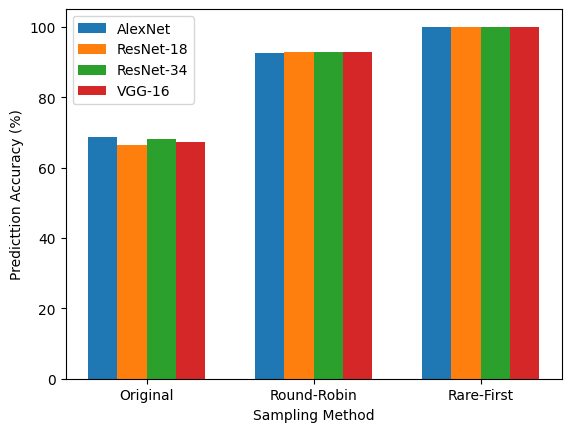

In [ ]:
metric = 'Predicttion Accuracy (%)' 
methods = ['Original', 'Round-Robin', 'Rare-First']
model_results = {
    'AlexNet': [68.70, 92.40, 100.00],
    'ResNet-18': [66.47, 92.88, 100.00],
    'ResNet-34': [68.02, 92.80, 100.00],
    'VGG-16': [67.31, 92.84, 100.00]
}

show_model_comparison(metric, methods, model_results)

Metric: Disease Recall (%)
--------------------------
[AlexNet]	 	Original: 57.38 	Round-robin: 98.97 	Rare-first: 100.00
[ResNet-18]	 	Original: 65.23 	Round-robin: 100.00 	Rare-first: 100.00
[ResNet-34]	 	Original: 65.32 	Round-robin: 99.91 	Rare-first: 100.00
[VGG-16]	 	Original: 61.78 	Round-robin: 100.00 	Rare-first: 100.00


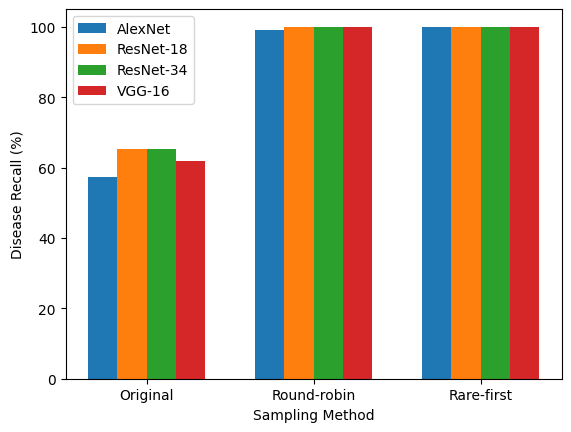

In [ ]:
metric = 'Disease Recall (%)'
methods = ['Original', 'Round-robin', 'Rare-first']
model_results = {
    'AlexNet': [57.38, 98.97, 100.00],
    'ResNet-18': [65.23, 100.00, 100.00],
    'ResNet-34': [65.32, 99.91, 100.00],
    'VGG-16': [61.78, 100.00, 100.00]
}

show_model_comparison(metric, methods, model_results)

The figures show the performance of different models using different sampling methods, respectively.
As described earlier, the metrics that we focus on here are the abnormality prediction accuracy and disease recall rate.

From the figures, we can see that round-robin sampling consistently improve the performance of all models compared to the original distribution, while rare-first sampling further pushes forward the performance to be almost optimal.
This demonstrates that our data preprocessing strategy handle the unbalanced data effectively.
In the context of medical diagnosis, this improvement can be critical for a practical application.

Training time per epoch on NVIDIA H100:

|      Model            | Training Time (s/epoch) |
| :---------------:     | :---------------------: |
|     AlexNet           |     3.7                 |
|     ResNet-18         |     6.1                 |
|     ResNet-34         |     9.0                 |
|     VGG-16            |     21.0                |

When comparing different models, we observe similar performance across them in the experiments.
Especially, VGG-16 has significantly more parameters than other models, and this results in longer training time.
However, this doesn't provide a better performance.
In contrast, AlexNet can provide comparable performence with a relatively short training time.
This result indicates that more parameters do not necessarily result in a better performance. When designing a deep learning system, we need to choose the architecture or model based on the scale and quality of the dataset and specific application scenarios.

Minimum training loss and validation loss at early stopping (round-robin sampling):

|      Model        | Traning Loss    | Validation Loss  |
| :---------------: | :-------------: | :--------------: |
|     AlexNet       |     0.177       |      0.313       |
|     ResNet-18     |     0.042       |      0.396       |
|     ResNet-34     |     0.038       |      0.431       |
|     VGG-16        |     0.038       |      0.729       |

The above table shows the traning loss and validation loss of differnt models when the training early stopped. With a larger number of parameters, VGG-16 has better learning ability than other models, which results in a smallest training loss. However, with limited training data, this also leads to a more obvious trend of overfitting, yielding a highest observed validation loss. This again validates our previous argument that it may not always be beneficial to have more parameters.

## Transformers Models

Vision Transformers (ViT) have gained significant attention in the field of computer vision due to their ability to capture long-range dependencies and contextual information. In this section, we implemented a ViT model from scratch and another using the pretrained weights from Hugging Face.

### ViT from Scratch

We implemented a Vision Transformer (ViT) model from scratch in PyTorch, following the original ViT-Base configuration. Specifically, the model consists of 12 transformer blocks with 12 attention heads each and a hidden size of 768.

A 2D convolutional layer is used to generate patch embeddings with a patch size of 16 and an embedding dimension of 512. The MLP layers within each block use a hidden dimension 4 times the hidden size.

In [1]:
import torch
import torch.nn as nn

class Patch_Embedding(nn.Module):
    """
    Module to split image into patches and embed them
    """
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        # x: [bs, in_channel, img_size, img_size]
        x = self.proj(x)  # [bs, embed_dim, height/patch_size, width/patch_size]
        x = x.flatten(2)  # [bs, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [bs, num_patches, embed_dim]
        return x

class Transformer_Layer(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        ) 
    def forward(self, x):
        # x: [seq_length, batch_size, embed_dim]
        # Self-attention block
        x_norm = self.norm1(x)
        x_att, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout1(x_att)
        # MLP block
        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)
        return x

class ViT(nn.Module):
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_channels=1,
            num_classes=15,
            embed_dim=768,
            depth=12,
            num_heads=12,
            mlp_dim=768*4,
            dropout=0.0
    ):
        super().__init__()
        self.patch_embed = Patch_Embedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([
            Transformer_Layer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)
    def forward(self, x):
        # x: [bs, in_channels, img_size, img_size]
        bs = x.shape[0]
        x = self.patch_embed(x)  # [bs, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(bs, -1, -1)  # [bs, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [bs, 1 + num_patches, embed_dim]
        x = x + self.pos_embed
        x = self.pos_drop(x)
        # Transformer expects shape [seq_length, batch_size, embed_dim]
        x = x.transpose(0, 1)
        for block in self.transformer_layers:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[0]  # shape: [bs, embed_dim]
        logits = self.head(cls_token_final)
        return logits

# Example usage
dummy_input = torch.randn(8, 1, 224, 224)
# Instantiate the Vision Transformer
model_args = {
    "img_size": 224,
    "patch_size": 16,
    "in_channels": 1,
    "num_classes": 15,
    "embed_dim": 768,
    "depth": 12,
    "num_heads": 12,
    "mlp_dim": 768 * 4,
    "dropout": 0.0
}
model = ViT(**model_args)
# Forward pass
output = model(dummy_input)
print("Output shape:", output.shape)  # [1, num_classes]

Output shape: torch.Size([8, 15])


The ViT model usually got its best validation accuracy at around 20 epochs, with the binary cross-entropy training and validation loss values both around $0.32$. After the first 20 epochs, the model starts to overfit, the training loss continues to decrease, while the validation loss starts to increase. The training process is usually stable, and the model converges well.

We compared the performance of the ViT from scratch model under different sampling strategies, and the results are shown in the table below. The evaluation is based on the model checkpoint with the best performance on the validation set.

| Sampling Strategy | Predict Acc (%) | Predict Recall (%) |
| :---------------: | :-------------: | :----------------: |
|     Original      |     62.91%      |       56.17%       |
|    Round-robin    |     92.88%      |      100.00%       |
|    Rare-first     |     100.00%     |      100.00%       |

From the table, we can see that the round-robin sampling strategy significantly improved the model's performance, achieving an accuracy of 92.88% and a recall of 100%. The rare-first sampling strategy achieved perfect accuracy and recall.

### Pretrained ViT

We encapsulated the ViT model from the `transformers` package to adapt it to our available pipeline. The model was fine-tuned using our preprocessed dataset after loading the pre-trained weights from Hugging Face.

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTConfig, ViTImageProcessor, ViTForImageClassification


class ViT_PT(nn.Module):

    def __init__(self, in_channels, num_classes, base_model_name="google/vit-base-patch16-224"):
        super().__init__()
        config = ViTConfig.from_pretrained(base_model_name)
        config.num_channels = in_channels
        config.num_labels = num_classes
        config.ignore_mismatched_sizes = True
        self.config = config
        self.tokenizer = ViTImageProcessor.from_pretrained(
            base_model_name, do_resize=False, do_rescale=True, do_normalize=False)
        self.base_model = ViTForImageClassification(config)

    def forward(self, x):
        assert x.shape[2] == self.config.image_size and x.shape[3] == self.config.image_size
        # x: [bs, in_channels, img_size, img_size]
        # Resize
        inputs = self.tokenizer.preprocess(images=x, data_format="channels_first",
                                           input_data_format="channels_first", return_tensors='pt')
        d = x.get_device()
        if d != -1:
            inputs = inputs.to(d)

        outputs = self.base_model(**inputs)
        return outputs.logits

The results for the fine-tuned ViT are shown in the following table shows the results for the ViT model after fine-tuning:

| Sampling Strategy | Predict Acc (%) | Predict Recall (%) |
| :---------------: | :-------------: | :----------------: |
|     Original      |     65.31%      |       57.20%       |
|    Round-robin    |     93.88%      |      100.00%       |
|    Rare-first     |     100.00%     |      100.00%       |

## Generative Models

Generative models have shown great promise in various applications, including image generation, text generation, and more. It also performs well in the abnormality detection task. In this section, we implemented generative models, including the Generative Adversarial Network (GAN) and the Denoising Diffusion Probabilistic Model (DDPM), to detect abnormalities in the medical images.

### Denoising Diffusion Probabilistic Model (DDPM)

We implemented a Denoising Diffusion Probabilistic Model (DDPM) incorporating the U-Net architecture. The DDPM model is trained to learn the distribution of the normal samples, and it can be used to detect abnormalities by generating samples from the learned distribution.

More specifically, after training on the normal samples, we hope the model can distinguish between normal and abnormal samples through the reconstruction loss of the backward diffusion process. As the model is trained to generate normal samples, it should have a much lower reconstruction loss for normal samples than for abnormal samples.

The DDPM initial noise scheduler is set to 0.0001, and the final noise scheduler is set to 0.02, with 1000 diffusion steps. The model is trained for 1000 epochs on the 20k normal samples. The implementation of the DDPM model is as follows.

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """
    Double convolution block used in UNet
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling with maxpool then double conv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling then double conv
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class SinusoidalPositionEmbeddings(nn.Module):
    """
    Time embedding for the UNet model
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class UNet(nn.Module):
    """
    U-Net architecture for noise prediction in DDPM
    """
    def __init__(
            self,
            in_channels=1,
            out_channels=1,
            base_channels=64,
            time_emb_dim=256
    ):
        super().__init__()
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        # Initial convolution
        self.inc = DoubleConv(in_channels, base_channels)
        # Downsampling path
        self.down1 = Down(base_channels, base_channels*2)
        self.down2 = Down(base_channels*2, base_channels*4)
        self.down3 = Down(base_channels*4, base_channels*8)
        self.down4 = Down(base_channels*8, base_channels*8)
        # Time embeddings for different levels
        self.time_mlp1 = nn.Linear(time_emb_dim, base_channels*2)
        self.time_mlp2 = nn.Linear(time_emb_dim, base_channels*4)
        self.time_mlp3 = nn.Linear(time_emb_dim, base_channels*8)
        self.time_mlp4 = nn.Linear(time_emb_dim, base_channels*8)
        # Upsampling path with skip connections
        self.up1 = Up(base_channels*16, base_channels*4)
        self.up2 = Up(base_channels*8, base_channels*2)
        self.up3 = Up(base_channels*4, base_channels)
        self.up4 = Up(base_channels*2, base_channels)
        # Final convolution
        self.outc = nn.Conv2d(base_channels, out_channels, kernel_size=1)
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)
        # Downsampling
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = x2 + self.time_mlp1(t_emb)[:, :, None, None]
        x3 = self.down2(x2)
        x3 = x3 + self.time_mlp2(t_emb)[:, :, None, None]
        x4 = self.down3(x3)
        x4 = x4 + self.time_mlp3(t_emb)[:, :, None, None]
        x5 = self.down4(x4)
        x5 = x5 + self.time_mlp4(t_emb)[:, :, None, None]
        # Upsampling with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # Final convolution
        logits = self.outc(x)
        return logits


class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model
    """
    def __init__(
        self,
        model,
        beta_start=1e-4,
        beta_end=0.02,
        num_timesteps=1000,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        super().__init__()
        self.device = device
        self.model = model.to(device)
        self.num_timesteps = num_timesteps
        # Define beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        # Pre-calculate different terms for closed form
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
    def forward_diffusion(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Takes an image and a timestep as input and returns a noisy version of the image
        """
        noise = torch.randn_like(x_0)
        mean = self.sqrt_alphas_cumprod[t][:, None, None, None] * x_0
        variance = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return mean + variance * noise, noise
    
    def sample_timesteps(self, n):
        """
        Sample timesteps uniformly for training
        """
        return torch.randint(low=1, high=self.num_timesteps, size=(n,), device=self.device)

    def p_losses(self, x_0, t, noise=None):
        """
        Training loss calculation
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        # Add noise to the input image according to the timestep
        x_noisy, target = self.forward_diffusion(x_0, t)
        # Predict the noise with the model
        predicted_noise = self.model(x_noisy, t)
        # Calculate the loss
        loss = F.mse_loss(predicted_noise, target)
        return loss
    
    def train_step(self, x, optimizer):
        """
        Perform a single training step
        """
        self.model.train()
        optimizer.zero_grad()
        # Sample random timesteps
        batch_size = x.shape[0]
        t = self.sample_timesteps(batch_size)
        # Calculate loss
        loss = self.p_losses(x, t)
        # Backpropagation
        loss.backward()
        optimizer.step()
        return loss.item()

# Example usage
unet = UNet(in_channels=1, out_channels=1)
ddpm = DDPM(unet)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)
# Dummy input
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_0 = torch.randn(32, 1, 224, 224).to(device)
loss = ddpm.train_step(x_0, optimizer)
print(f"loss: {loss}")

loss: 1.2003785371780396


At the end of the training process, the model achieved a training MSE reconstruction loss of around 0.0067. And we used the test set of both normal and abnormal samples to evaluate the model performance for five times. The mean MSE loss and the standard deviation of the five runs are shown in the table below.

| Data Type | Mean MSE Loss for 5 Runs | Std for 5 Runs |
| :-------: | :----------------------: | :------------: |
|  Normal   |         0.00708          |    0.00028     |
| Abnormal  |         0.00706          |    0.00044     |

From the results, we can see that the DDPM model got a very similar MSE $p$ loss for both normal and abnormal samples, with the standard deviation of the abnormal samples being slightly larger. This actually indicates that the model is not able to distinguish between normal and abnormal samples, and the model is not able to learn the distribution of the normal samples.

We think the reason for this is that, in the real-world medical diagnosis, the crucial part to detect the disease is only a small section of the image. However, for the DDPM model, it is trained to learn the distribution of the whole chest X-ray image. In this case, the slight difference in normal and abnormal samples is not enough for the model to learn the distinction.

### Generative Adverserial Network (GAN)

We implemented a Generator and Discriminator using a simple 2 & 4-layer CNN structure. The GAN model is trained to learn the distribution of the denoised PA images with Gaussian noise added to PA samples.

More specifically, after training on the PA samples, we hope the model can distinguish between noisy and denoised samples by reconstructing the denoised images the L1 reconstruction loss. Since AP images are taken in a emergency room setting and is more prone to noises, we are hoping the GAN to learn the noise distribution and applying it to denoise AP images for data augmentation.

The GAN was trained using Linear Warmup to 2e-4 and then a Linear decay for 15 epochs using a factor 0.5. This is to stabalise the GAN training. The L1 reconstruction loss lambda is set to be 0.1. 

In [ ]:
import torchvision.transforms.functional as TF
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1),
            nn.Tanh()
        )


    def forward(self, x):
        return self.decoder(self.encoder(x))

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=3, stride=2),  # Note: CHANNELS * 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1),
            nn.Sigmoid()
        )

    def center_crop_to_match(self, src, ref):
        _, _, h, w = ref.size()
        return TF.center_crop(src, [h, w])

    def forward(self, noisy, clean_or_fake):
        if noisy.size()[2:] != clean_or_fake.size()[2:]:
            clean_or_fake = self.center_crop_to_match(clean_or_fake, noisy)

        x = torch.cat([noisy, clean_or_fake], dim=1)
        return self.net(x)
    

LAMBDA_L1 = 0.1
# Dummy input
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
generator, discriminator = Generator(), Discriminator()

optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


noisy, clean  = torch.randn(32, 1, 224, 224).to(device),  torch.randn(32, 1, 224, 224).to(device)

fake_clean = generator(noisy).detach()
d_real = discriminator(noisy, clean)
d_fake = discriminator(noisy, fake_clean)


real = torch.ones_like(d_real) 
fake = torch.zeros_like(d_fake)
d_loss = criterion(d_real, real) + criterion(d_fake, fake)

optimizer_d.zero_grad()
d_loss.backward()
optimizer_d.step()

fake_clean = generator(noisy)
adv = discriminator(noisy, fake_clean)
adv_loss = criterion(adv, real) 
l1 = F.l1_loss(fake_clean, clean)
g_loss = adv_loss + LAMBDA_L1 * l1 

print(f"G loss: {g_loss}, D loss : {d_loss}")

Throughout the training process for 100 epochs, the model struggles to stablizes at a Discriminator loss of 0.5. This finding ties back to GAN's notorious instability for training. Even with extensive tuning of the L1 loss lambda and Linear Warmup, the Generator loss tends to overpower the Discriminator in late stages of training, leading to training D_loss =0.0007 and G_loss= 10.4171.

Nevertheless, we proceed to find out if the denoising augmentation helps in the training by finetuning a existing pretrained DenseNet121 by using the Generator weights where the Discriminator loss is approximately 0.5 at Epoch 13.

The finetuning process with pretrained DenseNet121 was carried out where 40% of the training samples are GAN-denoised. The finetuning was conducted using the balanced sampling method and evaluated on the original test set.

| Experiment (Densenet121) | Test Accuracy (%)  | Earlystop Epochs |
| :-------: | :----------------------: |  :------------: |
| Untrained classifier  |       44.3%         |   - |
| Finetuned classifier  |       92.7%       |  36 |
| GAN + Finetuned classifier |   91.6%    |   10  |


With GAN augmentation, the model did not have a significant increased in performance but it did speed up with the training convergence while acheiving a comparable accuracy and recall.

## Conclusion

In this project, we provided a comprehensive analysis of the NIH Chest X-ray dataset, including its multi-label nature, class imbalances, and variability in expert annotations. To overcome the skewed distribution of the dataset, we implemented different kinds of sampling strategies, including round-robin sampling and rare-first sampling, which served as data augmentation methods to increase the diversity of the training set. We also implemented and compared multiple architectures, including AlexNet, VGG, ResNet, and ViT variants, showing that lightweight CNNs and Transformers can achieve high accuracy when trained on balanced subsets. Finally, we explored generative approaches (DDPM and GAN) for abnormality detection, which proved less effective at distinguishing subtle pathologies.

## Further Work

1. **Uncertainty awareness training**: As menthioned in the data analysis part, the labels of the dataset actually get a considerable discrepancy with dignosis from human experts. But to deal with this uncertainty problem inside of the dataset may be out of the scope of this module. However, we still consider that it may be better to train the models with the uncertainty awareness methods, such as multi-model ensemble, to deal with the uncertainty problem.

2. **Incorporating object detection algorithms**: To further improve the accuracy of machine predictions, future work could integrate object detection techniques that localize and identify specific regions of interest (ROIs) within chest X-ray images. By leveraging algorithms (e.g. YOLO), the model can focus on clinically relevant areas, reducing background noise and enhancing the interpretability of predictions. This targeted approach may help the model better distinguish subtle pathological features, ultimately leading to more precise and reliable diagnostic outcomes.

## References

+ Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, and Ronald M Summers. Chestx-ray8: Hospital-scale chest x-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases. In Proceedings of The IEEE Conference on Computer Vision and Pattern Recognition, pages 2097–2106, 2017.

+ Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.

+ Alex Krizhevsky, Ilya Sutskever, and Geoffrey E Hinton. Imagenet classification with deep convolutional neural networks. Advances in Neural Information Processing Systems, 25, 2012.

+ Karen Simonyan and Andrew Zisserman. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556, 2014.

+ Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 770–778, 2016.

+ Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. Advances in Neural Information Processing Systems, 30, 2017.

+ Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, et al. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929, 2020.

+ Diederik P Kingma, Max Welling, et al. Auto-encoding variational bayes, 2013.

+ Ian Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. Generative adversarial networks. Communications of The ACM, 63(11):139–144, 2020.

+ Jonathan Ho, Ajay Jain, and Pieter Abbeel. Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems, 33:6840–6851, 2020.

+ Ronneberger Olaf, Philipp Fischer, and Thomas Brox. U-net: convolutional networks for biomedical image segmentation. In Medical Image Computing and Computer-assisted Intervention Conference Proceedings, part III 18: 234-241, 2015.